# Formalia:

Please read the [assignment overview page](https://github.com/suneman/socialgraphs2020/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

*If you fail to follow these simple instructions, it will negatively impact your grade!*

**Due date and time**: The assignment is due on Tuesday November 3rd at 23:55. Hand in your IPython notebook file (with extension `.ipynb`) via http://peergrade.io/.

### Overview

This year's Assignment 2 is all about analyzing the network of superheroes from the Marvel and DC universes. 

Note that this time, I'm doing the exercises slightly differently in order to clean things up a bit. The issue is that the weekly lectures/exercises include quite a few instructions and intermediate results that are not quite something you guys can meaning fully answer. 

Therefore, in the assignment below, I have tried to reformulate the questions from the weekly exercises into something that is (hopefully) easier to answer. *Then I also note which lectures each question comes from*; that way, you can easily go back and find additional tips & tricks on how to solve things 😇


----






In [1]:
# Add the necessary imports and settings
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk, re, pprint
from nltk import word_tokenize
from nltk.corpus import stopwords
%matplotlib inline
import copy
from wordcloud import WordCloud
import networkx as nx
from infomap import Infomap
import seaborn as sns
from collections import Counter
import seaborn as sns
from fa2 import ForceAtlas2
from operator import itemgetter
sns.set()
from pylab import *
import copy
import collections
import pickle
import csv

**Exercise 1**: Visualize the network (from lecture 5) and calculate basic stats (from lecture 4). For this exercise, we assume that you've already generated the network of superheroes, report work on the giant connected component.

Here's what you need to do:

*Exercise 1a*: Stats (see lecture 4 for more hints)
* What is the number of nodes in the network? <span style="color:blue"> 2339
* What is the number of links? <span style="color:blue"> 52,528
* What is the number of links connecting Marvel and DC? Explain in your own words what those links mean? <span style="color:blue"> 2455 interlinks. For explanation, see below.
* Who are top 5 most connected characters? (Report results for in-degrees and out-degrees). Comment on your findings. Is this what you would have expected. <span style="color:blue"> For tables and explanations, see below.
* Plot the in and out-degree distributions. <span style="color:blue"> See plots and discussion below.
    
  * Explain what you observe? <span style="color:blue"> See plots and discussion below.
  * Explain why the in-degree distribution is different from the out-degree distribution? <span style="color:blue"> See plots and discussion below.
* Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$. Comment or your results. <span style="color:blue"> See plots and discussion below.

In [6]:
# As it's assumed that we have the network already - here we load it in

with open('superherograph.gpickle', 'rb') as f:
    G = pickle.load(f)
    
# report work on the giant connected component.

gcc = max(nx.weakly_connected_components(G), key=len)
G_gcc = G.subgraph(gcc).copy()

In [7]:
# What's the number of nodes in the network? 

print("There are " + str(len(G_gcc.nodes)) + " nodes in the network.")

# What is the number of links?

print("There are " + str(len(G_gcc.edges)) + " links in the network.")

universe = nx.get_node_attributes(G_gcc,'universe')
interlink_count = 0
for edge in G_gcc.edges:
    if(universe[edge[0]] != universe[edge[1]]):
        interlink_count += 1

# What is the number of links connecting Marvel and DC?

print("\nThere are " + str(interlink_count) + " links between the universes in the network.")        

There are 2339 nodes in the network.
There are 52528 links in the network.

There are 2455 links between the universes in the network.


- ...Explain in your own words what those links mean?

<span style="color:blue"> This means that a Marvel or DC hero has a reference to a character outside of their own universe. See the small number as opposed to the total number of edges in the network (as most nodes only point to nodes in the same universe). The reason for these inter-universal links could be to draw parallels between heroes, citing inspiration for them or something similar. An additional explanation for the interlinks would be crossovers, where DC and Marvel heroes take each other on in battle. This should account for a number of the interlinks in our network. For information on DC versus Marvel Comics, see [here](https://en.wikipedia.org/wiki/DC_vs._Marvel#:~:text=DC%20versus%20Marvel%20Comics%20): 

In [4]:
# Who are top 5 most connected characters? (Report results for in-degrees and out-degrees). 

# Finding the heroes and their degrees

all_in_degs = sorted([[G_gcc.in_degree(node), node] for node in G_gcc.nodes], reverse=True)
all_out_degs = sorted([[G_gcc.out_degree(node), node] for node in G_gcc.nodes], reverse=True)

# Casting to Pandas dataframe to display

in_degs = pd.DataFrame(all_in_degs[:5], columns=["In degree", "Hero"], index=[i for i in range(1,6)])
out_degs = pd.DataFrame(all_out_degs[:5], columns=["Out degree", "Hero"], index=[i for i in range(1,6)])

print("\nTop 5 in degrees:")
display(in_degs)

print("\nTop 5 out degrees:")
display(out_degs)


Top 5 in degrees:


In degree             Hero
1        585         Superman
2        556           Batman
3        524       Spider-Man
4        493   Justice League
5        455  Captain America


Top 5 out degrees:


Out degree             Hero
1         205    Ultra Metallo
2         205    Super-Soldier
3         205    Lobo The Duck
4         205      Green Skull
5         205  Green Guardsman

- Comment on your findings. Is this what you would have expected.

<span style="color:blue"> For the in-degrees, the results are mostly as expected. Superman, Batman, Spider-Man, Justice League and Captain America are surely cited in a lot of different Wiki pages of heroes. This can be considered a natural phenomenon - these heroes are very widely known and beloved, and as such, will be part of many discussions surrounding the genre. The heroes of Marvel and DC are thus very likely to include references to these super-popular super-heroes.
    
<span style="color:blue"> As for the out-degrees, the heroes are relatively unknown. It's not outlandish to think that relatively unknown heroes have the highest out-degrees - it's just a matter of having many links on their WikiPage after all. Notice here that all the top five have the same out-degree. This is because these heroes are part of a reference WikiPage, and their documents are thus redirected and include a large number of links. This is the way the Wiki is structured, and a decision in the network design. These degrees will thus stay the way they are.

In [5]:
# Plot the in and out-degree distributions. 

# Since we're doing the same thing more than once, let's make a function:

def display_histogram_and_loglog_distributions(G_type, print_str, title, bins):
    degs = [deg for (node, deg) in G_type]
    hist, bin_edges = np.histogram(degs, bins=bins)
    degree_sequence = sorted([d for n, d in G_type], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig, axs = plt.subplots(1, 2,figsize=(15,5)) # Side-by-side comparison
    fig.suptitle(title)
    
    axs[0].hist(degs, bin_edges) # Histogram plot
    axs[0].set(ylabel='Frequency', xlabel='Degree')
    axs[0].set_title('Histogram of the {} distribution'.format(print_str)) # Setting a dynamic title    
    axs[1].loglog(bin_edges[:-1], hist, 'bo', markersize=4) # Log-log plot
    axs[1].set_title('Log-log of the {} distribution'.format(print_str))
    axs[1].set(ylabel='Frequency', xlabel='Degree');
    
    plt.show()

### <span style="color:blue">* But before we display the histogram and log-log distributions - let's explore if there's any outliers in the distributions...

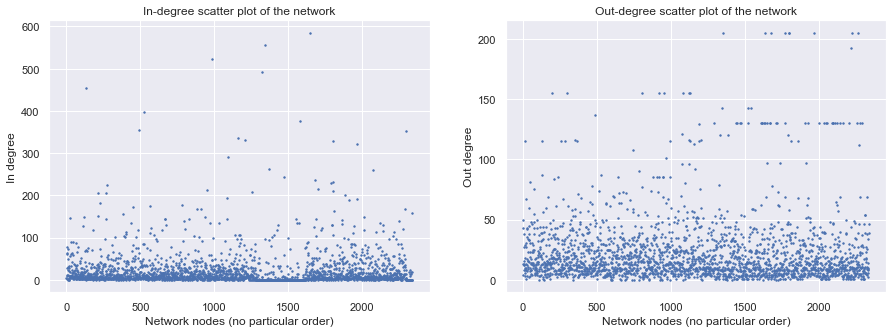

In [6]:
# Defining a scatterplot function to compare the in-degrees and the out-degrees

node_indices = [i for i in range(len(G_gcc.nodes))]
nodes = [node for node in G_gcc.nodes]

in_degrees = [G_gcc.in_degree(node) for node in G_gcc.nodes]
out_degrees = [G_gcc.out_degree(node) for node in G_gcc.nodes]

def make_scatter_plots():
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    
    axs[0].scatter(node_indices, in_degrees, s=2) # In-degree scatter
    axs[0].set_xlabel('Network nodes (no particular order)')
    axs[0].set_ylabel('In degree')
    axs[0].set_title('In-degree scatter plot of the network')
    
    axs[1].scatter(node_indices, out_degrees, s=2) # Out-degree scatter
    axs[1].set_xlabel('Network nodes (no particular order)')
    axs[1].set_ylabel('Out degree')
    axs[1].set_title('Out-degree scatter plot of the network')
    
    return axs

axs = make_scatter_plots()
plt.show()

<span style="color:blue"> The figures above show all network nodes and their respective in-degree (left) and out-degree (right). There's a clear difference in the distribution - the in-degree distribution has more of a tendency to hover around the bottom. To demonstrate this, let's see where the high percentiles lie in these distributions:

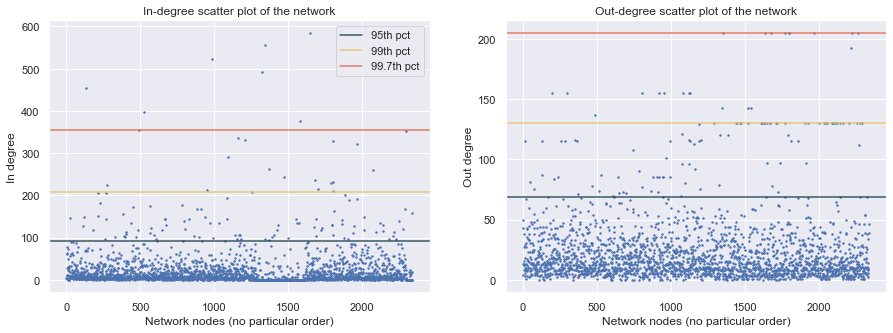

In [7]:
# Finding percentiles

percentiles = [95, 99, 99.7] # Defining three high percentiles to explore
colours = ["#264653", "#e9c46a", "#e76f51"] # And their colours

axs = make_scatter_plots()

for i in range(len(percentiles)):
    # Drawing line for each percentile on each graph
    axs[0].axhline(y=np.percentile(in_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")
    axs[1].axhline(y=np.percentile(out_degrees, percentiles[i]), c=colours[i], xmin=0, xmax=1, alpha=0.9, label=str(percentiles[i])+"th pct")

axs[0].legend()
plt.show()

<span style="color:blue"> The figures above show where the high percentiles lie in the in-degree and out-degree distributions. It would seem that even though the in-degrees go up to almost 600 for the top heroes, 95% of heroes have less than 100. Let's find out who these heroes are that are so far ahead of the norm (99.7th percentile):

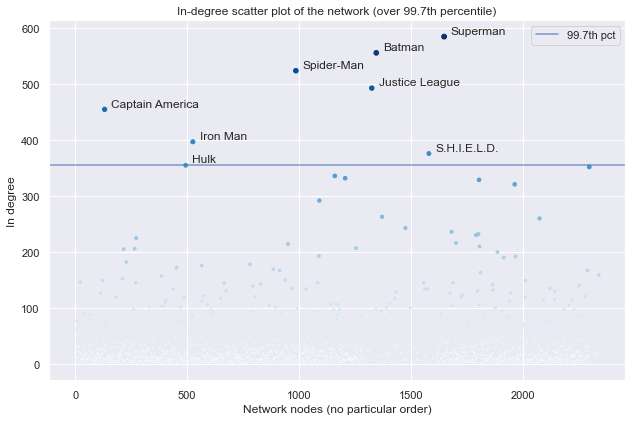

In [8]:
# Let's build the scatter plot again, with more detail around the top:

fig=plt.figure(figsize=(8,5))
ax=fig.add_axes([0,0,1,1])
ax.scatter(node_indices, in_degrees, s=[degree / 25 for degree in in_degrees], c=in_degrees, cmap="Blues") # Size map included
ax.set_xlabel('Network nodes (no particular order)')
ax.set_ylabel('In degree')
ax.set_title('In-degree scatter plot of the network (over 99.7th percentile)')

# Adding the horizontal line for the 99.7th percentile

plt.axhline(y=np.percentile(in_degrees, 99.7), xmin=0, xmax=1, alpha=0.7, label="99.7th pct")   
    
# And annotating the top degrees

for n in range(len(in_degrees)):
    if in_degrees[n] > np.percentile(in_degrees, 99.7):
        plt.text(n+30, in_degrees[n]+5, nodes[n])

plt.legend()        
plt.show()

<span style="color:blue"> The figure above shows the same scatterplot as before, but with gradient colouring and point sizes by the heroes' in-degrees. Heroes with in-degrees over the 99.7th percentile have their names noted. This figure shows just how far ahead a few heroes are, as they have a very large amount of references with other heroes! This makes sense, as these are the same few heroes we found to have the highest in-degrees earlier in this exercise. 
    
### <span style="color:blue">* This brief intermission was to show that the in-degree distribution has a number of extreme outliers that are far from the norm. But now let's plot the distributions as a whole:

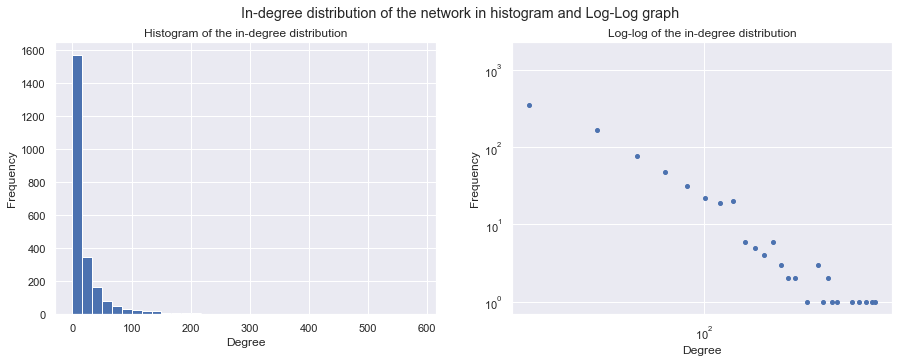

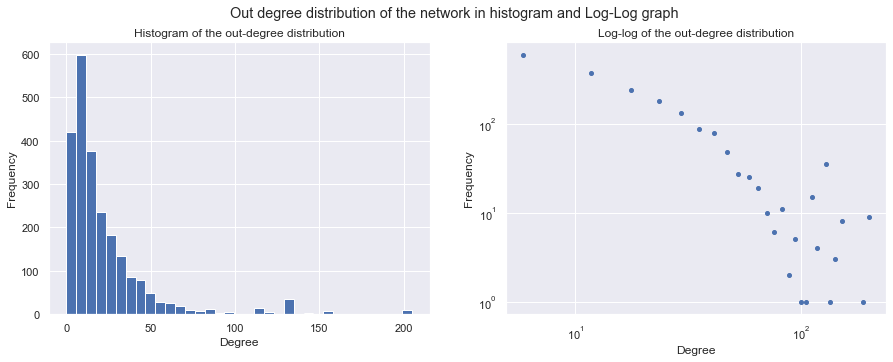

In [9]:
# Now we can call the original function to display a histogram and log-log graph of the degrees and compare

display_histogram_and_loglog_distributions(G_type=G_gcc.in_degree(), bins=35, print_str="in-degree", title="In-degree distribution of the network in histogram and Log-Log graph")
display_histogram_and_loglog_distributions(G_type=G_gcc.out_degree(), bins=35, print_str="out-degree", title="Out degree distribution of the network in histogram and Log-Log graph")

<span style="color:blue"> The figures above show histograms and log-log graphs of in-degree and out-degree distributions in the network. 

* Explain what you observe? 

<span style="color:blue"> For the in-distribution, there is a whole lot of heroes that have no references elsewhere. In fact, the most common in-degree by far is 0. On the other end of the spectrum - there are also very few heroes that get referred to by a lot of other heroes (> 500), but these do not show in the histogram. That's why we get a dramatically downward slope in the distribution, and no clusters towards the extreme end of highest degree heroes (Superman, Batman and such). These heroes are indeed miles ahead of the lowest degree heroes. It would appear that in-degrees is a winner-takes-all game. 
    
<span style="color:blue"> When looking at out-degree distribution, however, most heroes tend to refer to between 0 and 20 other heroes. 20 to 40 or 50 is still common, but there's a nice downwards slope towards the higher end of the spectrum (which is a much lower number than the in-degree maximum, at 205). 
    
<span style="color:blue"> One thing to note about the out-degree distributions is, however, that some heroes tend to have the same out-degree (for example, 205). Notice the bars around 200, 150, and between 100-150. This is because of the previously noted effect that some heroes' WikiPages are redirects to a larger community page. These community pages include many links, and these heroes are thus displayed as having the same out-degrees. This is on account of the WikiPage contents, and as such will not be changed.


* Explain why the in-degree distribution is different from the out-degree distribution?
    
<span style="color:blue"> The difference makes a lot of sense. Each hero's WikiPage links to some number of other heroes. Which heroes is it likely to link to? Of course - the WikiPage must include general information on the Universe in which the hero belongs to, the clique they hang out with, and the villains they aim to put in jail. 
        
<span style="color:blue">But the distribution is not evenly distributed. By far most heroes have almost nobody linking to them - but they link to other, more known heroes that they are (or should like to be) associated with in some way. These other heroes could be considered hubs with a very large amount of incoming connections from less connected nodes. To support this, please refer to the figures above: The in-degree distribution goes up to 600, whereas the out-degree distribution only around 200. The most obvious example of such a hub is Superman, the most linked to hero, being mentioned in the WikiPage of many hundreds of other heroes. This trend is likely to continue - with new heroes being born, they most likely will have no incoming links themselves, and they will most likely link to already popular heroes, maybe Superman.


In [10]:
# Compare the degree distribution to a random network with the same 
# number of nodes and probability of connection 𝑝. 

# We will do an undirected graph here
G_und = G_gcc.to_undirected()

# Getting the average degree of the network
k = sum([deg[1] for deg in G_und.degree()]) / len(G_und.degree)

<font color='blue'>Recall that the value of $p$ is found by: $p = \frac{<k>}{(N-1)}$</font>


In [11]:
# Computing probability of connection p, as per the formula above
p = k / (len(G_und.nodes) -1)

# Creating the comparable random network
rnd_G = nx.erdos_renyi_graph(len(G_und.nodes()), p, seed=1, directed=False)

# Let's check if we have a good network here
print("Actual network (undirected): ")
print(nx.info(G_und))
print("----------------------------")
print("\nRandom network: ")
print(nx.info(rnd_G))

Actual network (undirected): 
Name: 
Type: Graph
Number of nodes: 2339
Number of edges: 46163
Average degree:  39.4724
----------------------------

Random network: 
Name: 
Type: Graph
Number of nodes: 2339
Number of edges: 46156
Average degree:  39.4664


<span style="color:blue"> Great! Now we have a random network with very similar properties to our superhero network. Right? ... Right?

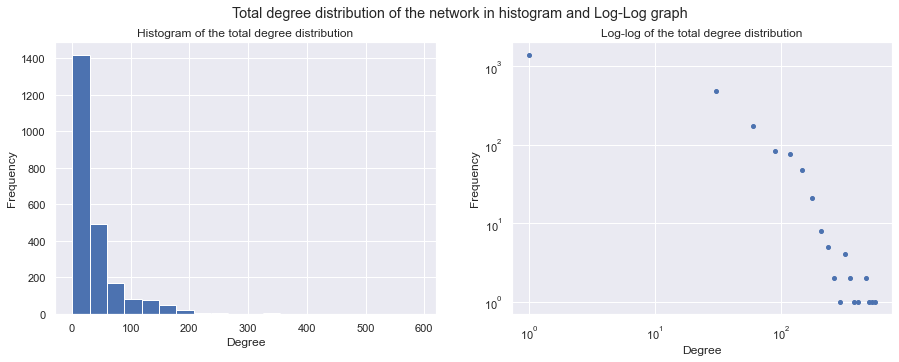

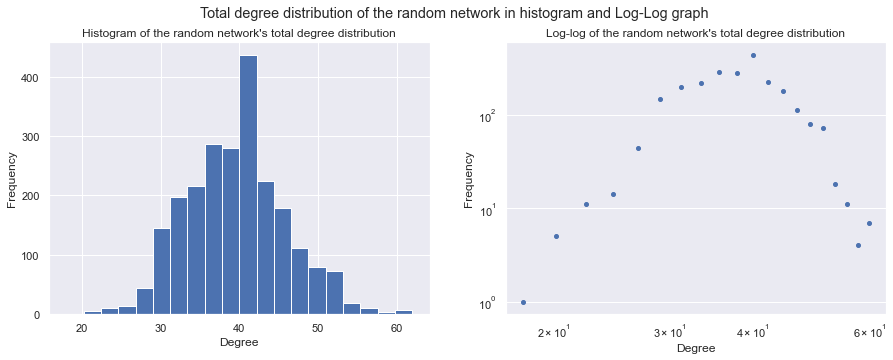

In [12]:
# Let's visualise the *total* degree distribution of this random network vs ours:

display_histogram_and_loglog_distributions(G_type=G_und.degree(), bins=20, print_str="total degree", title="Total degree distribution of the network in histogram and Log-Log graph")
display_histogram_and_loglog_distributions(G_type=rnd_G.degree(), bins=20, print_str="random network's total degree", title="Total degree distribution of the random network in histogram and Log-Log graph")

<span style="color:blue"> The figures above show a histogram and log-log graph of the total degree distribution in the superhero network (top) and the random network just generated (bottom).

Comment on your results.

<span style="color:blue"> The difference is certainly stark. The random network follows a very nice normal distribution around the average degree (around 40), whereas most of the real network's nodes have very few degrees. In the real network, there are a lot of loners. As we look at more "popular" nodes, the fewer nodes there are to look at. Again, on the extreme end of the spectrum, there are a few nodes that are really, really popular.  
    
<span style="color:blue"> In the random network, having almost no degrees is very rare. At the other end, having more than 60 degrees is also very rare. The distribution is very even, and all the heroes get to know quite a fair number of other heroes. The real network is, however, sadly not a random one, dooming many heroes to a life of loneliness.

*Exercise 1b*: Visualization (see lecture 5 for more hints)

* Create a nice visualization of the total network. <span style="color:blue"> See visualisation below.
    
  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm

In [13]:
# As with any visualisation - it's mostly about sizes and colour:

# Define node and edge colors
col_a = '#264653'
col_b = '#e9c46a'
col_c = '#e76f51'

col_a_soft = '#bed7e1'
col_c_soft = '#f5c5b8'

# Create lists of the correct colors and sizes for edges and nodes
edge_colors = [col_a_soft
               if G_und.nodes[u]['universe']=='Marvel' and G_und.nodes[v]['universe']=='Marvel' 
               else col_c_soft if G_und.nodes[u]['universe']=='DC' and G_und.nodes[v]['universe']=='DC' else col_b for (u,v) in G_und.edges]

node_colors = [col_a if universe=='Marvel' else col_c for (node, universe) in G_und.nodes.data('universe')]

node_sizes = [degree  for (node, degree) in G_und.degree()]

In [14]:
# If you can get it to work, get node positions based on the Force Atlas 2 algorithm

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=0.8,
    
    # Performance
    jitterTolerance=0.3, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.5,
    
    # Tuning
    scalingRatio=30.0,
    strongGravityMode=True,
    gravity=10.0,
    
    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(G_und, pos=None, iterations=2000);

100%|██████████| 2000/2000 [02:38<00:00, 12.66it/s]

BarnesHut Approximation  took  26.00  seconds
Repulsion forces  took  123.29  seconds
Gravitational forces  took  0.07  seconds
Attraction forces  took  4.63  seconds
AdjustSpeedAndApplyForces step  took  1.42  seconds


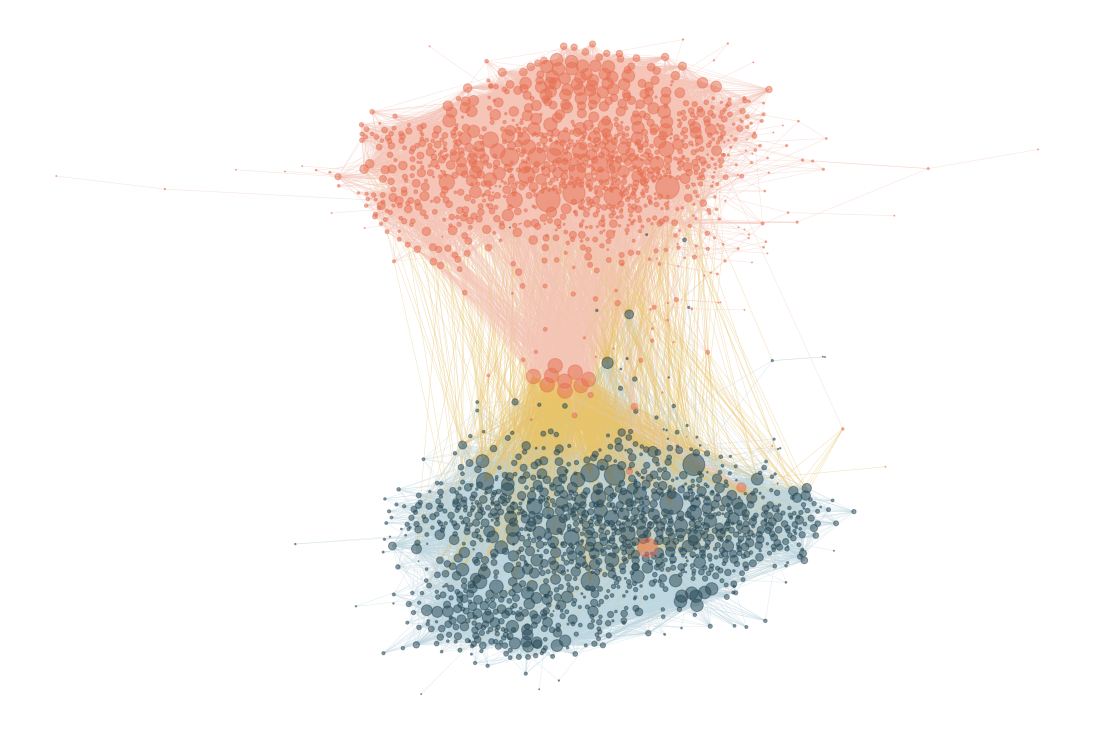

In [15]:
# And we're ready to visualise:

plt.figure(figsize=(15,10))

nx.draw(G_und, positions, node_color = node_colors, with_labels = False, node_size = node_sizes, edge_color = edge_colors, width=0.5, alpha=0.5);

<span style="color:blue"> The above figure shows the undirected GCC of the Marvel and DC universe. The blue-coloured nodes are part of the Marvel univeres, whereas the red nodes are part of DC. Node links within the Marvel universe are coloured in soft blue, and the links within the DC universe in soft red. Inter-universe links are coloured in yellow. Additionally, node sizes are adjusted by their degree. There's a very clear distinction between the two universes, in spite of the inter-connectivity. 

#### End of Exercise 1.

___

**Exercise 2**: Create your own version of the TF-TR word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the wiki-pages.

Here's what you need to do:

* That's it, really. The title says it all. Create your own version of the TF-TR word-clouds. Explain your process and comment on your results.

<font color='blue'> The first step to creating the TF-TR word clouds for each superhero universe is to extract all the words from their respective wikipages. In order to do so it is necessary to have the documents accessible via the folder structure presented below. All of the wikipages where downloaded from the web and saved to a text file. The files were sorted into two folders, one for each universe.
    
To be able to count the frequency of words appearing in the universes two lists are created, one for each universe. The list contains all the words from all the wikipages of the respective universe. The words have been cleaned up by filtering out non-word text, making everything lowercase, tokenizing and lemmatizing the words. Additionally common stop words where filtered out. The results are two lists **dc_words** and **marvel_words** that contain all of the words that meet the formentioned criteria.

In [3]:
# Generate the list of filenames for each universe
dc_files = os.listdir('./character_wiki_pages/dc')
marvel_files = os.listdir('./character_wiki_pages/marvel')

# Generate the words lists for each universe
dc_words = []
marvel_words = []

# Create a lemmatization object to use and stopwords
stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()

# Loop through all the DC
for filename in dc_files:
   
    filepath = './character_wiki_pages/dc' + '/' + filename              # generate the filepath
    file = open(filepath)                                                # open the file
    raw = file.read()
    raw = BeautifulSoup(raw, 'html.parser').get_text()                   # read the text from the html raw text
    raw = raw.replace('-', '')                                           # lets combine words with hyphens first
    tokens = word_tokenize(raw)                                          # get the words, skip punctuation and make everything lowercase
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]  # Lemmatize the words and skip stopwords
    dc_words.extend(lem_words)                                           # Add to wordlist


# Do the same for all the marvel files
for filename in marvel_files:
    filepath = './character_wiki_pages/marvel' + '/' + filename
    file = open(filepath)
    raw = file.read()
    raw = BeautifulSoup(raw, 'html.parser').get_text()
    raw = raw.replace('-', '')
    tokens = word_tokenize(raw)
    words = [w.lower() for w in tokens if w.isalpha()]
    lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords]
    marvel_words.extend(lem_words)

<font color='blue'>The lengths of both documents are pretty similar, so there is no real need to make any specific adjustments before it is possible to continue.

In [4]:
dc_length = len(dc_words)
marvel_length = len(marvel_words)
print("DC length: ", dc_length)
print("Marvel length: ", marvel_length)

DC length:  2406915
Marvel length:  2097390


<font color='blue'>From the word lists it is possible to convert the word lists into a frequency dictionary, where each dictionary includes all the unique words in the list along with their freqency or raw count. An example of 5 most common words for both universes can be seen below.

In [5]:
# Now we have two lists of all the words used in each universe and create the freq dist for each
fdist_dc = nltk.FreqDist(dc_words)
fdist_marvel = nltk.FreqDist(marvel_words)
fdist_marvel.most_common(5)

[('comic', 68381),
 ('marvel', 43822),
 ('character', 17478),
 ('xmen', 12025),
 ('spiderman', 11869)]

In [6]:
# Similarly for the dc universe
fdist_dc.most_common(5)

[('comic', 53227),
 ('dc', 25802),
 ('batman', 18682),
 ('character', 17028),
 ('series', 14502)]

<font color='blue'> In order to see if correcting for the documents length would result in a difference in the final wordcloud, the frequency distributions where duplicated and each one of them normalized by the total word count in the list. That way both lists will have more comparable values, since they will be of similar scale. 

In [7]:
# Now we want to normalize the frequency by length of each word list
fdist_marvel_norm = copy.deepcopy(fdist_marvel)
fdist_dc_norm = copy.deepcopy(fdist_dc)

# Normalize marvel frequencies
#most_frequent_marvel = fdist_marvel.most_common(1)[0][1]

for word in fdist_marvel_norm:
    fdist_marvel_norm[word] = fdist_marvel[word] / marvel_length
    
# Normalize marvel frequencies
#most_frequent_dc = fdist_dc.most_common(1)[0][1]

for word in fdist_dc_norm:
    fdist_dc_norm[word] = fdist_dc[word] / dc_length

# Print the results for Marvel
fdist_marvel_norm.most_common(5)

[('comic', 0.0326029017016387),
 ('marvel', 0.020893586791202397),
 ('character', 0.008333214137570981),
 ('xmen', 0.005733316169143555),
 ('spiderman', 0.005658938013435746)]

In [8]:
# print the results for DC
fdist_dc_norm.most_common(5)

[('comic', 0.022114200127549166),
 ('dc', 0.010719946487516178),
 ('batman', 0.007761802971854012),
 ('character', 0.007074616261895414),
 ('series', 0.0060251400651871794)]

<font color='blue'>
Now the frequencies of each word have been normalized by the length of each word list.
This way the lists between universes are slighlty more comparable.

<br>
    
Next step is to pull out the the words that are special about each of these two universes. In order to do that a modified version of the TF-IDF strategy will be used. Since there are only two groups the standard versions can result in weird results.
    
The term frequencies will be weighted using additional information about what is unique to each universe. So that words that are unique to a specific universe will have a high weight in that universe, but a low weight in the other universe. Words that occur with the same frequency in both lists will be neutral.
    
For the analysis the term ratios (TR) will be used.

In general for some token $t$ with term frequency $\textrm{TF}^{(u)}_t$, in universe $u$ where $u \in \{Marvel,DC\}$, we define the weight as:

$$w_{t}^{(Marvel)} = \frac{\textrm{TF}^{(Marvel)}_t}{ \textrm{TF}^{(DC)}_t + c}, \qquad \textrm{and} \qquad w_{t}^{(DC)} = \frac{\textrm{TF}^{(DC)}_t}{ \textrm{TF}^{(Marvel)}_t + c}. $$

In both cases, the constant $c$ is added to the denominator in case a word occurs zero times. This avoids the 'division by zero error'. A change in the value of $c$ has an effect on the results.

After the weights for both lists have been defined the ranking of token $t$ on list $u$ is given by $\textrm{TF}^{(u)}_t \times w_{t}^{(u)}$. These are the so called **TF-TR** lists. 

    
The **TF-TR** lists have the properties that the weight associated with a word is large when a word occurs much more frequently in the list considered, compared to the other list. It's small when a word is rare in our list and frequent in the other. And it's approximately equal to one, when the word is equally frequent in both lists. (The downside is that it only works when you're finding important terms with two lists).

This method is not the only option for TR weights but this is a good option when comparing two documents. A decent ranking can be computed by combining the term frequency with a weighting scheme.
    
Next step codewise is to generate the tf_tr lists for each universe.

In [9]:
# First we copy the frequency dictionary and use that as a base, where we will overwrite the values
tf_tr_marvel = copy.deepcopy(fdist_marvel)
tf_tr_dc = copy.deepcopy(fdist_dc)

# Do the same for the normalized version
tf_tr_marvel_norm = copy.deepcopy(fdist_marvel_norm)
tf_tr_dc_norm = copy.deepcopy(fdist_dc_norm)

# Define the c constant
c = 10

# Calculate the ratios for marvel
for key in tf_tr_marvel.keys():
    # Count number of occurances in each universe
    marvel_count = fdist_marvel[key]         
    dc_count = fdist_dc[key]
    
    ratio = marvel_count / (dc_count + c)            # Calculate new ratio
    tf_tr_marvel[key] = ratio * fdist_marvel[key]    # Overwrite the value in tf_tr_marvel with the ratio * tf
    tf_tr_marvel_norm[key] = ratio * fdist_marvel_norm[key]    # do the same for the normalized version
    
# Calculate the ratios for dc using the same method as above
for key in tf_tr_dc.keys():
    marvel_count = fdist_marvel[key]
    dc_count = fdist_dc[key]
    ratio = dc_count / (marvel_count + c)
    tf_tr_dc[key] = ratio * fdist_dc[key]
    tf_tr_dc_norm[key] = ratio * fdist_dc_norm[key]

<font color='blue'>Since **tf_tr_marvel** and **tf_tr_dc** are still frequency distributions, it is simple to use the in-built function ***most_common()*** to find the most common values in the dictionary. Below the top 10 values for DC and Marvel are shown. The most frequent words are the same for both the TF and normalized TF versions. Only the values are different. (not shown)

In [10]:
# Display the top 10 values for DC - since this is a freq dist we can use inbuilt functions
tf_tr_dc.most_common(10)

[('batman', 4532689.922077922),
 ('superman', 2544148.3205128205),
 ('lantern', 1881792.0),
 ('dc', 1668529.3333333335),
 ('bizarro', 1602872.8181818184),
 ('sinestro', 782880.4),
 ('league', 567289.5728643216),
 ('supergirl', 543456.8181818182),
 ('superboy', 535484.4545454545),
 ('gotham', 528775.2)]

In [11]:
tf_tr_marvel.most_common(10)

[('xmen', 1853854.1666666665),
 ('marvel', 691525.9935181851),
 ('avenger', 667571.8128342247),
 ('spiderman', 445801.14240506326),
 ('hulk', 401278.2407407408),
 ('wolverine', 363802.6176470588),
 ('mutant', 344593.5208333334),
 ('thor', 229265.47272727272),
 ('deadpool', 179525.40000000002),
 ('morlocks', 172659.6)]

<font color='blue'> The values presented above are the top **TF-TR** values for each universe. It can be seen that these results make sense since **tf_tr_dc** constains terms that relate very strongly to DC, while **tf_tr_marvel** contains terms that are contained within the Marvel universe.
    
The last and final step is to create the wordcloud. Since the information is contained in a frequency distribution it is easy to plot the results using the ***generate_from_frequencies*** method of the ***WordCloud*** module.
Below the word clouds for DC and Marvel are plotted side by side for easier comparison.

In [12]:
# Define the settings and input to the wordclouds - DC
wordcloud_dc = WordCloud(background_color='White',   
                         width=1000, 
                         height=500, 
                         colormap="plasma"
                        ).generate_from_frequencies(tf_tr_dc)

# Define the settings and input to the wordclouds - Marvel
wordcloud_marvel = WordCloud(background_color='White',   
                             width=1000, 
                             height=500, 
                             colormap="viridis"
                             ).generate_from_frequencies(tf_tr_marvel)

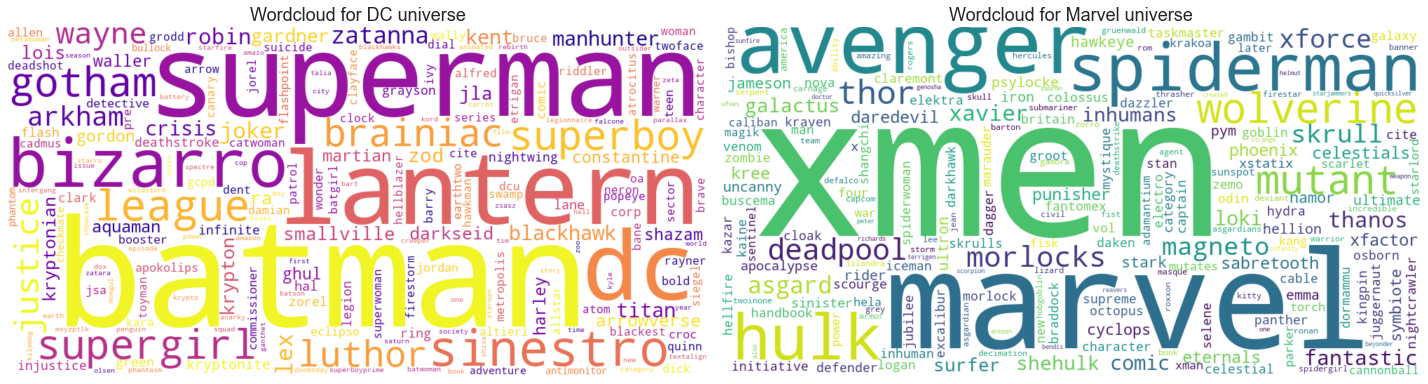

In [13]:
# Finally both wordclouds are plotted side by side
plt.figure(figsize=(20,15))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_dc, interpolation='bilinear')
plt.title("Wordcloud for DC universe", fontsize=18)
plt.axis("off")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_marvel, interpolation='bilinear')
plt.title("Wordcloud for Marvel universe", fontsize=18)
plt.axis("off");

<font color='blue'>
From the above wordclouds it is very clear that this method has resulted in the most informational and distinct words being displayed for each universe. The results make sense since for DC the biggest heroes are in fact Batman and Superman. Other frequently mentioned characters are Bizarro, Sinestro and supergirl. Other relevant terms are for example lantern which relates to both the character Green latern and the White Lantern Corps.
Similarly for Marvel the X-men are very aparent, along with the Marvel name. A commonly appearing and relevant term is Avengers which relates to the superhero team. Other prominent characters are Spiderman, Magneto, Hulk, Wolverine, Deadpool and Thor, which are all a part of the Marvel universe. Other non-character specific terms that are prominent in the wordcloud are Asgard, home to Thor, and 'mutant' which relates to the fact that the X-men are mutant superheroes and therefore this term both appears frequently, has a high association to the X-men and is pretty distinctive to the Marvel universe.

## <font color='blue'>* **Comparison between TF and normalized TF detour**
<font color='blue'>    
As a final step lets examine if there is a big difference between the normal TF and the normalized TF, that corrected for the different lengths of documents. Now the two wordclouds for DC will be plotted side by side.

In [14]:
# Define the settings and input to the wordclouds - DC - normalized version
wordcloud_dc_norm = WordCloud(background_color='White',   
                         width=1000, 
                         height=500, 
                         colormap="plasma"
                        ).generate_from_frequencies(tf_tr_dc_norm)

# Define the settings and input to the wordclouds - Marvel - normalized version
wordcloud_marvel_norm = WordCloud(background_color='White',   
                             width=1000, 
                             height=500, 
                             colormap="viridis"
                             ).generate_from_frequencies(tf_tr_marvel_norm)

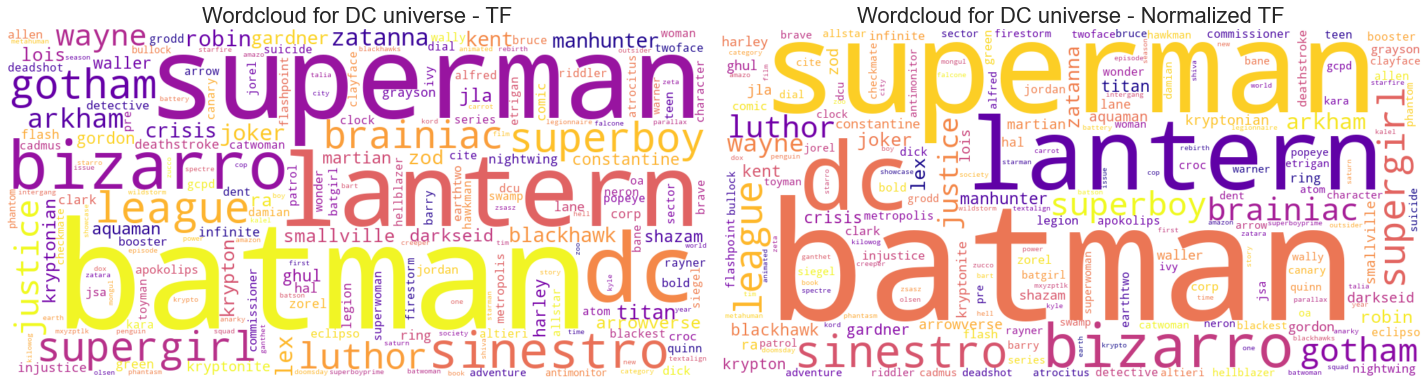

In [15]:
# Finally both wordclouds are plotted side by side
plt.figure(figsize=(20,15))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_dc, interpolation='bilinear')
plt.title("Wordcloud for DC universe - TF", fontsize=22)
plt.axis("off")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_dc_norm, interpolation='bilinear')
plt.title("Wordcloud for DC universe - Normalized TF", fontsize=22)
plt.axis("off");

<font color='blue'>From the above it is clear that most terms stay pretty consistant between the two wordclouds. The same words are still present in both wordclouds, but it is clear that there have been some changes in the word sizes. The normalized version shows some terms slightly smaller, indicating that these are mentioned frequently, but when corrected for the document length, these terms are not as frequent as they first appeared. In general the changes are very minor.
    
Finally the same wordcloud comparison is done for the Marvel universe.

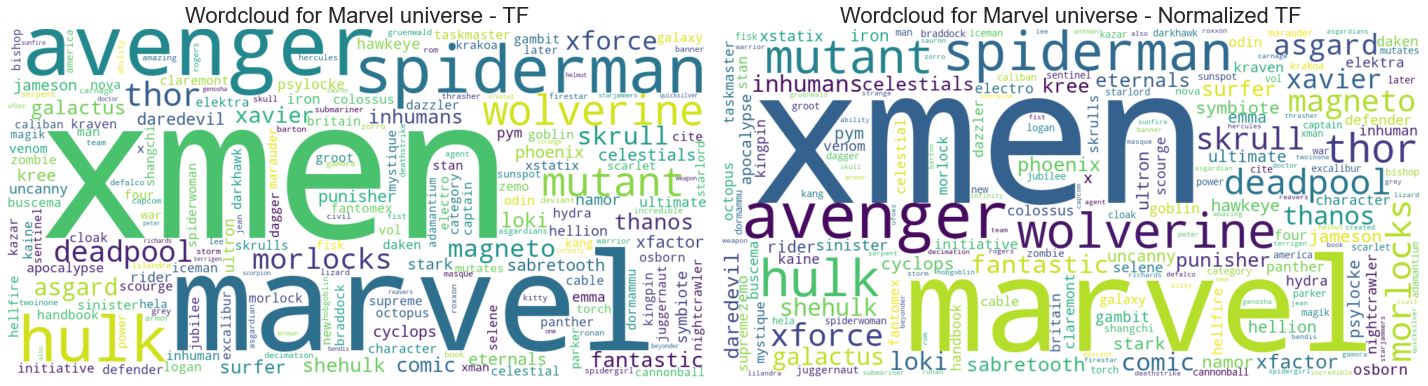

In [16]:
# Finally both wordclouds are plotted side by side
plt.figure(figsize=(20,15))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_marvel, interpolation='bilinear')
plt.title("Wordcloud for Marvel universe - TF", fontsize=22)
plt.axis("off")
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_marvel_norm, interpolation='bilinear')
plt.title("Wordcloud for Marvel universe - Normalized TF", fontsize=22)
plt.axis("off");

<font color='blue'>There are slight differences between these two wordclouds but everything remains pretty similar.
    
<br>
    
As a conclusions it seems that since there was such a relatively minor difference in the word lengths of the different document, that normalizing the TF values with respect to document length of each list did not make a huge difference. It was however interesting to check if the difference would be drastic or not.
    
<br>
<br>
    
**End of exercise 2**    

<hr>
    
    

**Exercise 3**: Find communities and create associated TF-IDF word clouds (from lecture 7 and 8). In this exercise, we assume that you have been able to find communities in your network. It's OK to only work on a single universe in this one.

Here's what you need to do:
* Explain briefly how you chose to identify the communities: Which algorithm did you use, how does it work?
* How many communities did you find in total?
* Plot the distribution of community sizes.
* For the 5-10 largest communities, create TF-IDF based rankings of words in each community. There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.
* Create a word-cloud displaying the most important words in each community (according to TF-IDF). Comment on your results (do they make sense according to what you know about the superhero characters in those communities?)

<font color='blue'>For this exercise the focus will be on the Marvel universe.
    
    
Here the communities of the Marvel universe will be extracted using the Infomap community detection algorithm.
The reason for the choice was that according to the teachers this algorithm outperform the Python-Louvain algorithm.

According to the homepage of [Infomap](https://www.mapequation.org/publications.html) many community detection algorithms, including the popular modularity maximization approach, infer module assignments (communities) from an underlying model of the network formation process. The Infomap approach is to focus on how a network's extant structure influences the system's behavior, in this case the networks' flow. To highlight and simplify the network structure with respect to this flow, the map equation is used. The authors state:
<blockquote>The differences between the map equation and the modularity maximization approach are not merely conceptual. Because the map equation attends to patterns of flow on the network and the modularity maximization approach does not, the two methods can yield dramatically different results for some network structures.</blockquote>   
    
In this [paper](https://www.mapequation.org/assets/publications/EurPhysJ2010Rosvall.pdf) the authors define the map function as 
    <blockquote>
    $L(M) = qH(Q) + \sum\limits_{i=1}^m p^iH(P^i) $
    </blockquote>
Where $M$ is a module partition and $L(M)$ is the lower bound on code length. $H(Q)$ is the frequency-weighted average length of codewords in the index codebook and $H(P^i)$ is the frequency-weigthed average length of codewords in module codebook i (the community). Further the terms are weighted by the rate at which the codebooks are used. With $q$ as the probability that a random walker switches modules on any given step. The $p^i$ probability is the fraction of time the random walk spends in module i plus the probability that it exits the module and the exit message is used. [Source](https://www.mapequation.org/assets/publications/EurPhysJ2010Rosvall.pdf)
    
Clearly the above is not a very simple explanation but [this answer](https://stackoverflow.com/questions/48528648/infomap-community-detection-understanding/54292999#:~:text=The%20basic%20idea%20behind%20the,random%20walker%20exploring%20your%20graph) on stack owerflow provides a great explaination (slightly summarised below):
    
<blockquote>
The basic idea behind the Infomap algorithm is to use community partitions of the graph as a Huffman code that compresses the information about a random walker exploring your graph. The central object is a random walker exploring the network with the probability that the walker transitions between two nodes given by its Markov transition matrix. Each node is coded with an individual codeword in the network. In most real-world networks, there are regions of the network such that once the random walker enters a region, it tends to stay there for a long time and movements between regions are relatively rare. This allows us to combinatorially combine codewords into Huffman codes: we can use a prefix code for each region, and then use a unique codeword for each node within a module, but we can reuse these node level codewords for each module. 
    
The same intuition can be gathered by looking at a street names; it would be crazy to have a unique street name for every street in the US, instead, we use states and towns, and then specify a street name, allowing us to reuse street names between towns (how many Main streets are there?)

Then the optimization algorithm comes onto the scene: when you use too few modules, you are effectively still back at the level of using an individual codeword for every node, but use too many modules, and the number of prefix codes becomes to large. Therefore it is needed to find an optimal partition that assigns nodes to modules, such that the information needed to compress the movement of our random walker is minimized.

The difference from Modularity community detection methods is that Infomap focuses on the information needed to compress the movement of the random walker, while Modularity defines modules based on edge density (more edges within a module than expected by chance).</blockquote>   
    

<font color='blue'>In order to compute the communities within the Marvel network, the first step was to load the complete directed hero network from the previously pickled object. Then the Marvel nodes are filtered out into a seperate subgraph and the GCC extracted. The directed version of the Marvel GCC subgraph will be used for the computation but all ForceAtlas plotting will be done on the undirected version of the same subgraph.

In [8]:
# The first step is to extract the marvel nodes from the network along with the GCC

# Read the saved graph
G = nx.read_gpickle("heroes_directed.gpickle")

# Find all the marvel nodes
marvel_nodes = [node for (node, data) in G.nodes(data=True) if data.get("universe") == "Marvel"]

# Create a subgraph of only the Marvel nodes
Mavel_G = G.subgraph(marvel_nodes)

# Extract the GCC
Marvel_G_gcc = G.subgraph(max(nx.weakly_connected_components(G.subgraph(marvel_nodes)), key=len))

# Also create an undirected version for plotting later on
Marvel_G_gcc_und = nx.to_undirected(Marvel_G_gcc)

* **How many communities did you find in total?**

<font color='blue'>The Infomap community detection algorithm found a total of 43 communities within the undirected Marvel GCC subgraph. The algorithm in the below codecell shows the computation, but a more detailed explanation of the algorithm can be found at the start of the exercise.

In [9]:
# Now let's use the Infomap algorithm to find the communities - NOTE WE ARE USING THE DIRECTED VERSION

im = Infomap() # Generate the infomap object

node_list = [node for node in Marvel_G_gcc.nodes()] # generate the nodelist
im_map = {}

# Add the nodes to the infomap
for i in range(len(Marvel_G_gcc.nodes)):
    im.add_node(i, node_list[i]) # Add all the nodes along with their names
    im_map[node_list[i]] = i     # Create a dictionary that maps between names and node IDs

# Add the edges to the infomap
for edge in Marvel_G_gcc.edges:
    im.add_link(im_map[edge[0]], im_map[edge[1]])

# Run the algorithm
im.run()

# How many communities did you find in total?
print(f"Found {im.num_top_modules} communities.")

Found 43 communities.


<font color='blue'>Finally the community information is added to each node of the network, so that it can be easily accessed later on. A single print statements was also added to show that this works as intended.

In [10]:
# Now we save information about each community number in a dictionary
modules = im.get_modules()

# Create a dictionary of hero name and community number
communities = {}
for node in Marvel_G_gcc_und.nodes:
    communities[node] = modules[im_map[node]]
    
# Get all the community values in a single variable
infomap_communities = communities.values()  

# Count and sort the communities
communities_counter = Counter(infomap_communities).most_common(max(infomap_communities))

# Add the community numbers to an attribute within the graph
nx.set_node_attributes(Marvel_G_gcc_und, communities, "community")

# Print a single hero to see that this worked
list(Marvel_G_gcc_und.nodes(data=True))[0]

('Blackwing', {'universe': 'Marvel', 'community': 1})

* **Plot the distribution of community sizes.**

<font color='blue'> First lets explore a bar chart of all the communities along with their sizes, to get a sense of the communities.

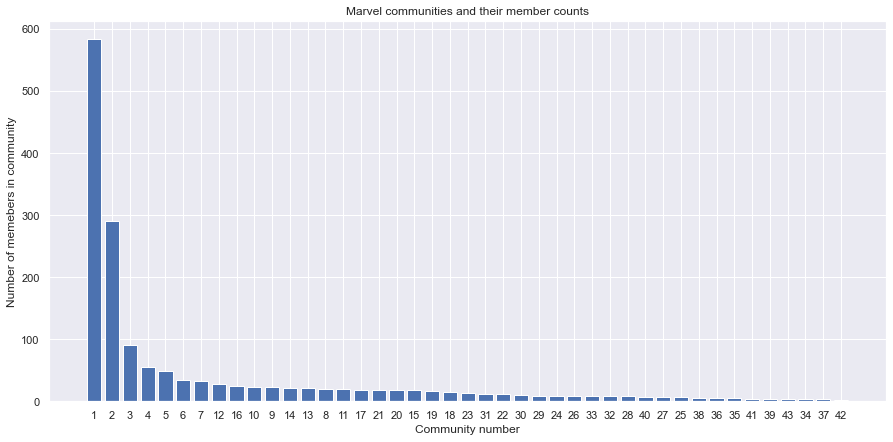

In [13]:
# Lets plot the communities and see how many are in each one
plt.figure(figsize = (15,7))

labels, values = zip(*communities_counter)
indexes = np.arange(len(labels))

plt.bar(indexes, values)
plt.xticks(indexes, labels)
plt.xlabel('Community number')
plt.ylabel('Number of memebers in community')
plt.title('Marvel communities and their member counts')
plt.show()

<font color='blue'>The bar chart above shows clearly that the first two communities (1 and 2) are of a much greater scale than the other communities. 41 of the 43 communities have less than 100 members and some of the last communities displayed only have very few members.
    
To visualize this distribution even better a histogram of the community sizes was created. That way the communities of similar sizes are binned together.

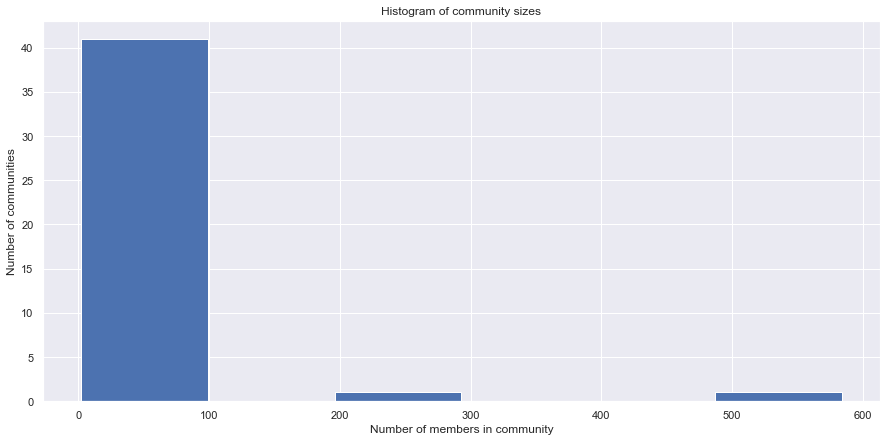

In [27]:
# Compute the community sizes along with their hist info and bin_edges
community_sizes = [e[1] for e in communities_counter]
hist, bin_edges = np.histogram(community_sizes, bins=6)

# Plot the histogram
plt.figure(figsize = (15,7))
plt.hist(community_sizes, bin_edges) 
plt.title("Histogram of community sizes") 
plt.xlabel('Number of members in community')
plt.ylabel('Number of communities')
plt.show()

<font color='blue'>From the above histogram the information presented before can be seen even more clearly. Over 40 communities have a size in the range 0-100, 1 community has a size ranging around 200-300, and finally the single biggest community has a size ranging between around 500-600. This means that there are two communities considerably bigger than the rest but the majority of communities have less than 100 members.

## <font color='blue'>* **A little plotting detour.**
    
<font color='blue'>    
Out of curiosity it was believed to be interesting to plot the network with different colors for the communities, using the ForceAtlas plotting. To make the graph as clear as possible only the biggest 10 communities will be plotted in color. But as shown above the rest of the communities have relatively few members, so this should still result in an informative plot.
<br>
    
First the information on the communities of each node are collected and the information about which communities are the top 10 communities. Additionally the top 10 heroes will be generated so they can be labeled in the later graphs

In [32]:
# Generate the numbers of the top 10 communities and top 6 communities
top_10_communities = [el[0] for el in Counter(infomap_communities).most_common(10)]

# Let's find out the 'biggest' nodes
nodes = dict(sorted(nx.degree_centrality(Marvel_G_gcc_und).items(), key = itemgetter(1), reverse = True)[0:10])
top_nodes = list(nodes.keys())

<font color='blue'>First 10 distinct colors are extracted from the 'Set1' colormap and added to a vector. Then the ForceAtlas settings and positions are defined and in this case the outboundAttractionDistribution is set equal to False in order to dissuade hubs.

100%|██████████| 2000/2000 [00:51<00:00, 38.93it/s]


BarnesHut Approximation  took  11.90  seconds
Repulsion forces  took  37.95  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.35  seconds
AdjustSpeedAndApplyForces step  took  0.44  seconds


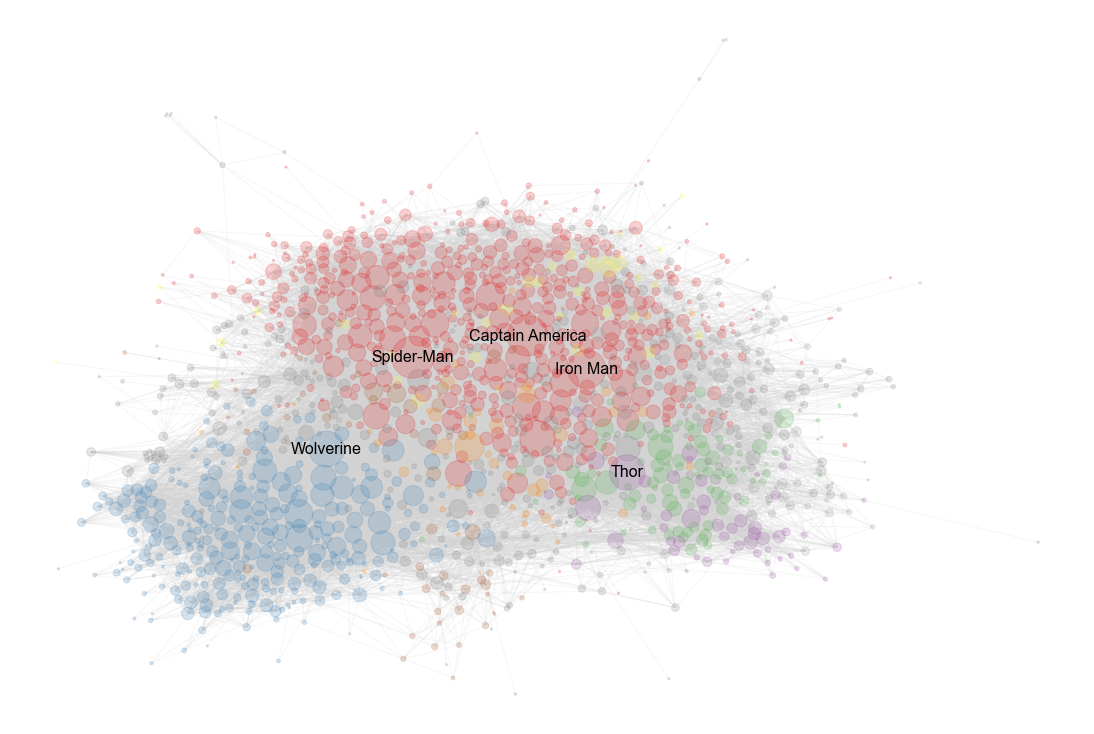

In [23]:
# Finally lets plot these results on the undirected version of the graph - NOTE HERE WE USE UNDIRECTED FOR PLOTTING
cmap = cm.get_cmap('Set1', 10) # create 10 colors to use for plotting

colors = []

for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))
#print(colors)

# Lets plot the Marvel communities using the Force Atlas algorithm.
plt.figure(figsize=(15,10))

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = False, # Dissuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.2, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5.0,
    strongGravityMode=True,
    gravity=1.0,
    
    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(Marvel_G_gcc_und, pos=None, iterations=2000)

# Generate sizes based on node centrality
node_sizes = list(nx.degree_centrality(Marvel_G_gcc_und).values())
node_sizes = [round(num,3) for num in node_sizes]
node_sizes = [num*5000 for num in node_sizes]

# Lets try only coloring in the 10 biggest communities - other minor communities will be gray
# Otherwise it gets to confusing
node_colors = [colors[top_10_communities.index(m)] if (m in top_10_communities) else '#808080' for m in infomap_communities]

# Generate the graph
nx.draw(Marvel_G_gcc_und, positions, with_labels = False, node_size = node_sizes, 
        node_color = node_colors, edge_color = 'lightgray', alpha=0.2);

# Generate the labels
labels = {}    
for node in Marvel_G_gcc_und.nodes():
    if node in top_nodes[:5]:
        #set the node name as the key and the label as its value 
        labels[node] = node

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(Marvel_G_gcc_und, positions, labels, font_size=16, font_color='black');


<font color='blue'>From the graph above it is clear that the different communities seem to have their respective areas. The Red and Blue communities are clearly the two biggest communities and a pretty clear seperation is between them.
With the top 5 'biggest' heroes plotted, it is pretty clear that **Wolverine** is the biggest node within the blue community. **Spider-Man, Captain America and Iron Man** are within the Red community and **Thor** is within the purple community.
    
Another interesting graph could be generated by changing the forceatlas settings and allowing for hubs to be created on the plot. That way the biggest nodes would be plotted even more clearly. 

100%|██████████| 2000/2000 [00:49<00:00, 40.11it/s]


BarnesHut Approximation  took  12.86  seconds
Repulsion forces  took  35.41  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.40  seconds
AdjustSpeedAndApplyForces step  took  0.45  seconds


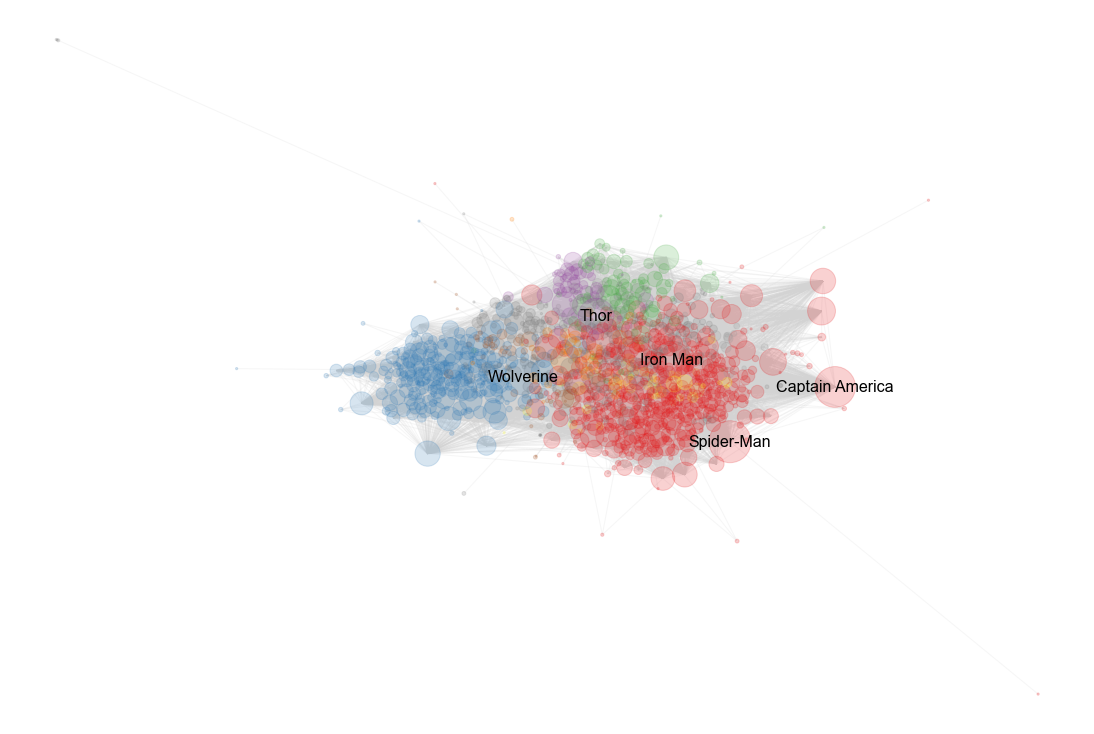

In [24]:
# Finally lets plot these results on the undirected version of the graph - NOTE HERE WE USE UNDIRECTED FOR PLOTTING

# Let's create the plot again with hubs being present
plt.figure(figsize=(15,10))

forceatlas3 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution = True, # Persuade hubs
    edgeWeightInfluence=1,
    
    # Performance
    jitterTolerance=0.7, # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,
    
    # Tuning
    scalingRatio=5.0,
    strongGravityMode=True,
    gravity=50.0,
    
    # Log
    verbose=True
)

positions3 = forceatlas3.forceatlas2_networkx_layout(Marvel_G_gcc_und, pos=None, iterations=2000)

# Generate the graph
nx.draw(Marvel_G_gcc_und, positions3, with_labels = False, node_size = node_sizes, 
        node_color = node_colors, edge_color = 'lightgray', alpha=0.2);

# Now draw only the labels of the top nodes
nx.draw_networkx_labels(Marvel_G_gcc_und, positions3, labels, font_size=16, font_color='black');


<font color='blue'>From the above plot we can see an even more distinctive split between some of the communities. The green community is slightly more visible than before. However as before only around 5 communities appear to be most visible even though the top 10 communities are colored in. This could be explained by the fact that this graph is plotted in 2D, so the seperation could perhaps be more clear in a dimension that can not be visualized in this 2D graph.

* **For the 5-10 largest communities, create TF-IDF based rankings of words in each community. There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.**<br><br>
<font color='blue'>

    **TF - Term frequency**<br>
    In order to create the Wordclouds it was decided to use the TF adjusted for document length instead of the raw count TF. The difference is that the adjusted frequency aims to prevent bias towards longer document, by dividing the raw frequency by the document length. That way all the terms in each document are normalized by the document length. This was believed to be important since the communities are of vastly different sizes and also have very different document lengths.
    
    **IDF - Inverse Document Frequency**<br>
The IDF is a measure of how much information the word provides, i.e., if it's common or rare across all documents.

    If the regular inverse document frequency is used $log\left(\frac{N}{n_t}\right)$, words that appear in all document will be excluded from the wordclouds. This would result in the word 'Comic' being excluded since it appears in every community and therefore is not particularly descriptive of any one community. Originally this was used but the formula presented a specific problem when computing the wordclouds.

    If the inverse document frequency smooth $log\left(\frac{N}{1+n_t}\right)+1$ is used, words that appear in all documents will not be excluded. This would result in 'Comic' being represented as a prominent word in all the community wordclouds, even though it is not distinctive of any one community. However, this would also result in very descriptive community terms being excluded, such as **Spiderman** simply because the character is referenced in each community. This would lead to the wordcloud for the most dominent and largest community (community 1) to be less descriptive than the other community wordclouds. 
   
    Therefore it was decided to use the the **inverse document frequency smooth** formula, but manually exclude some of the words that were found to be non-descriptive of the communities in the wordclouds.
    
    **TF-IDF**<br>
    Finally the TF-IDF can be defined by multiplying the TF and IDF together for each term in each community.

<font color='blue'> First a function is defined that generates the wordlist of each community and returns the frequency distribution of the words in a specified community, after the values have been divided by the document length (TF adjusted as described above).

In [25]:
# Function that returns the frequency distribution of words for each community
def tf_community(community_number):

    # Extract all the members of the community
    members = [node for (node, data) in Marvel_G_gcc_und.nodes(data=True) if data.get("community") == community_number]

    # Generate the list of filenames for marvel universe
    marvel_files = os.listdir('./character_wiki_pages/marvel')

    # Generate the words lists for the community
    community_words = []

    # Create a lemmatization object to use and stopwords
    stopwords = nltk.corpus.stopwords.words('english')
    wnl = nltk.WordNetLemmatizer()
    
    # Manual stopwords - common wikipedia 'words'
    manual_stopwords = ['http', 'cite']
    
    # Loop through all the marvel files for the specified community and add the words to the wordlist for dc
    for filename in marvel_files:
        if filename[:-4] in members:
            filepath = './character_wiki_pages/marvel' + '/' + filename            # generate the filepath
            file = open(filepath)                                # open the file
            raw = file.read()
            raw = BeautifulSoup(raw, 'html.parser').get_text()   # read the text from the html raw text
            raw = raw.replace('-', '')                           # lets combine words with hyphens first
            tokens = word_tokenize(raw)                          # get the tokens
            words = [w.lower() for w in tokens if w.isalpha()]   # skip punctuation and make everything lowercase
            lem_words = [wnl.lemmatize(w) for w in words if w not in stopwords] # Lemmatize the words and skip stopwords
            lem_words = [w for w in lem_words if w not in manual_stopwords] # Filter out manual stopwords
            community_words.extend(lem_words)  # Add to wordlist

    # Now we have a list of the words used in the community and create the freq dist for it
    fdist_community = nltk.FreqDist(community_words)
    
    # Now we normalize the raw counts by the word of the document
    for word in fdist_community:
        fdist_community[word] /= float(len(community_words))
    
    return fdist_community

<font color='blue'> Now we run the adjusted TF function on the top 10 communities and show the results of the 3 most common words in each community

In [26]:
# Collect the top communities into a dictionary
tf = {}
for community_number in top_10_communities:
    tf['community_%s' % community_number] = tf_community(community_number)
    
for community in tf:
    print(community, tf[community].most_common(3))

community_1 [('comic', 0.031066458669608405), ('marvel', 0.021559955377637607), ('spiderman', 0.011518795872995462)]
community_2 [('comic', 0.034436181612419015), ('xmen', 0.020580965613209268), ('marvel', 0.01705488615401795)]
community_3 [('comic', 0.03235315472300879), ('marvel', 0.025404777463152544), ('galactus', 0.009279024177739055)]
community_4 [('comic', 0.03882380644021899), ('thor', 0.02933125331135574), ('marvel', 0.027491611232118678)]
community_5 [('comic', 0.029508483470351583), ('strange', 0.029053699492740948), ('marvel', 0.024313451110722407)]
community_6 [('comic', 0.03652058432934927), ('initiative', 0.02095617529880478), ('marvel', 0.019123505976095617)]
community_7 [('comic', 0.03166953528399311), ('warrior', 0.02512908777969019), ('new', 0.02046628070724456)]
community_12 [('comic', 0.03360757915731738), ('flight', 0.032460732984293195), ('alpha', 0.017601595612066815)]
community_16 [('comic', 0.03910891089108911), ('eternals', 0.03483910891089109), ('marvel', 0.

<font color='blue'> From the results above it can be seen that the most common term in all communities is 'comic'. However the term frequency has been adjusted by the document length, so it can now be seen that the term 'comic' is actually proportionally most frequent in community_10. The raw counts would not have indicated this, as community_10 is the smallest community, with the least number of wikipages, and therefore among the shortest community documents.


<font color='blue'>
    Next the IDF is computed by using the inverse document frequency smooth formula as described previously. Finally the TF-IDF is generated for each word in each community.

In [27]:
# Create a copy where we will overwrite the values to include the tf idf
tf_idf = copy.deepcopy(tf)

# for each word in each community - count in how many lists it appears
for community in tf: # For each community
    for word in tf[community]: # for each word in the community

        doc_count = 0 # reset doc count
        
        for inner_community in tf: # For all communitites (again)
            if word in tf[inner_community].keys(): # if the word is a key in the inner community
                doc_count = doc_count + 1 # increase the doc count          
      
        tf_idf[community][word] = tf[community][word] * (math.log(10 / (doc_count+1))+1) # tf * Inverse document frequency

* **Create a word-cloud displaying the most important words in each community (according to TF-IDF). Comment on your results (do they make sense according to what you know about the superhero characters in those communities?)**

<font color='blue'>
As mentioned above the wordclouds would be less informative if words that appear in all communities would be left out. However there are still some words that appear in all communities frequently but are not informative of the community memebers in anyway. To make the wordclouds clearer a few words where manually collected and the filtered out before the wordcloud of each community was generated.<br>
    
    
***Comments on the wordclouds can be found under the figure at the end of exercise 3.***
    
First the wordcloud objects where created for each community from the frequencies of the new filtered dictionaries.

In [28]:
# Collect the word cloud objects into a dictionary
wordclouds = {}

# For the wordcloud we want to create our own list of stopwords that even after the TF-IDF occur prominently in
# each community but don't add a lot of information about the community
manual_stopwords = set(['marvel', 'comic', 'character', 'category']) # Skip a few very common words and wikiwords

for idx, community_number in enumerate(top_10_communities):
    
    dictionary = tf_idf['community_%s' % community_number]
    filtered_dict = {key: value for (key, value) in dictionary.items() if key not in manual_stopwords}
    
    wordclouds[community_number] = WordCloud(collocations=False, 
                                             background_color='White', 
                                             width=800, 
                                             height=400, 
                                             colormap="plasma",
                                             #stopwords = manual_stopwords  ### this does not work with generate_from_frequencies
                        ).generate_from_frequencies(filtered_dict)

<font color='blue'> Lastly a loop was used to generate all the subplots needed to plot the 10 wordclouds together in a single figure.

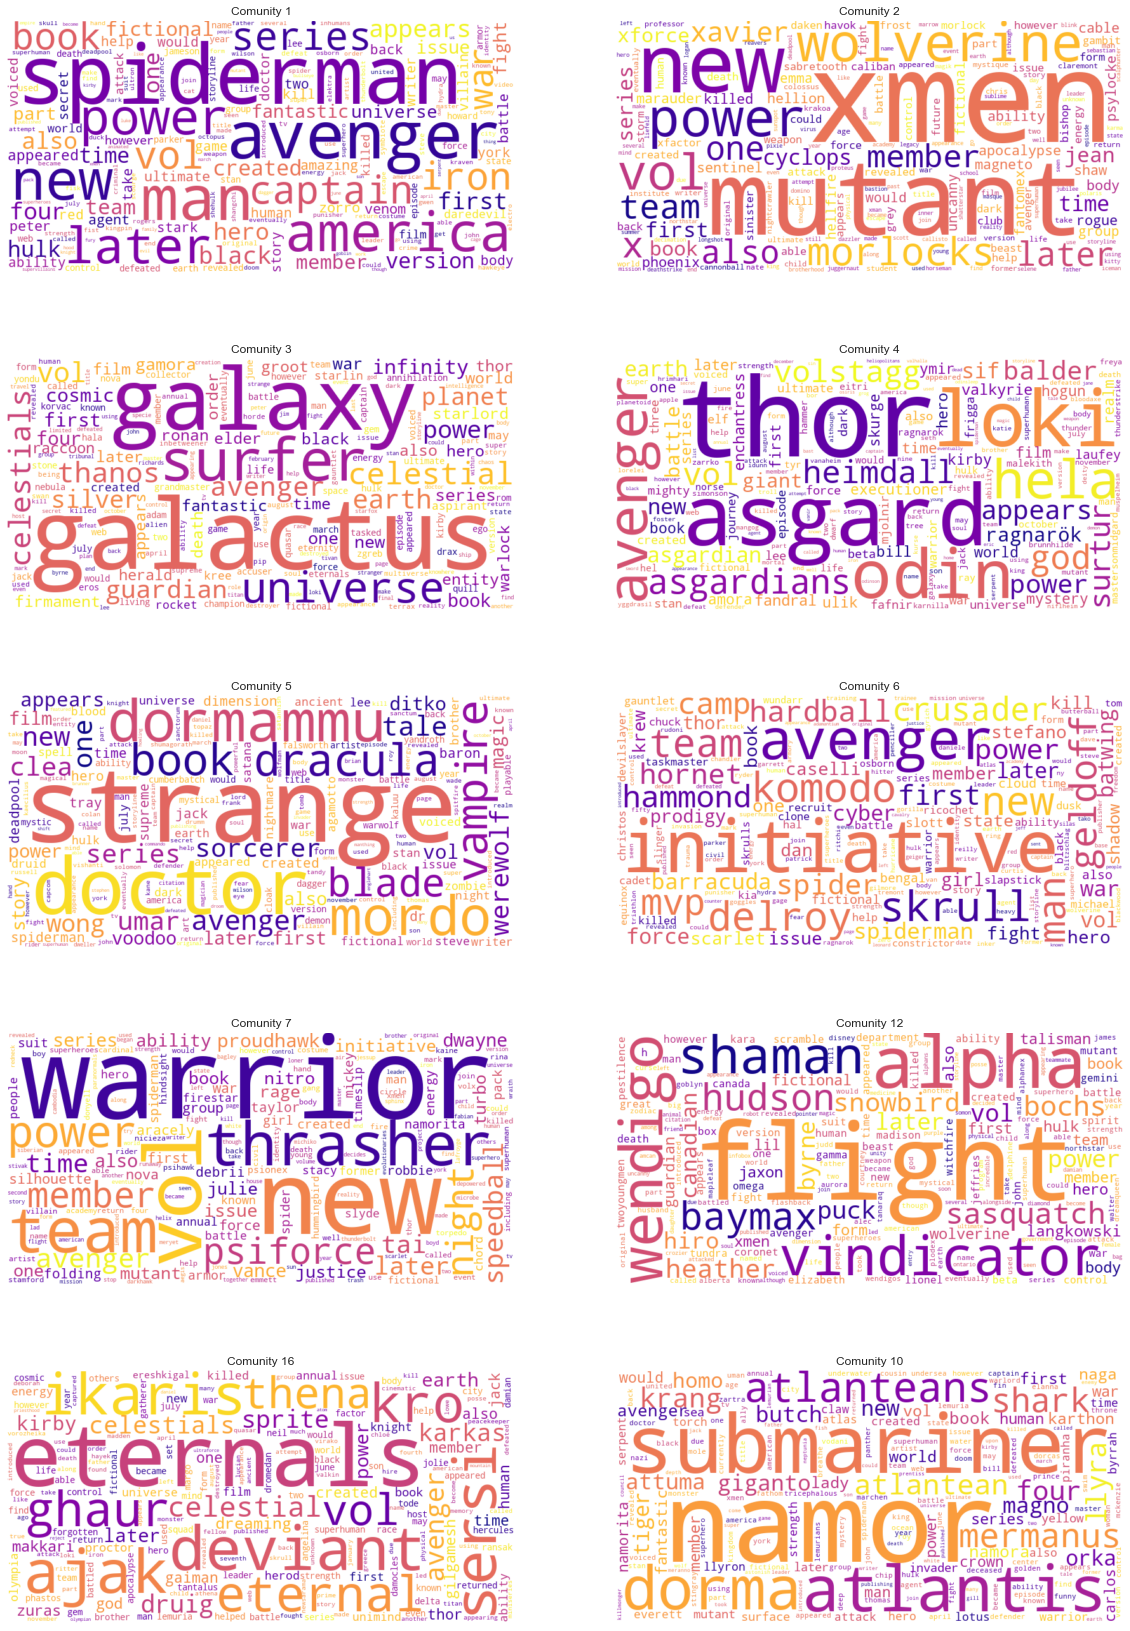

In [29]:
# Generate a single figure
plt.figure(figsize=(20,30))

for idx, community_number in enumerate(wordclouds):
    plt.subplot(5, 2, idx+1);
    plt.imshow(wordclouds[community_number], interpolation='bilinear');
    plt.title("Comunity %s" % community_number);
    plt.axis("off");

* **Comment on your results (do they make sense according to what you know about the superhero characters in those communities?)**

<font color='blue'>Generally the wordclouds seem to make sence according to our knowledge of the Marvel universe and its superheroes. The top 10 characters (based on degree centrality) for the top 10 communities are displayed in a table below for reference. All of the communities have the prominent characters of the community displayed along with terms that seem to be highly connected and specific to those communities. A further detailed breakdown of each wordcloud is presented below:
    
**Community 1**<br>
The most prominent terms here are **Spiderman**, **Avenger**, **America**, **New**, **Power**, **Iron**, **Man** and **Captain**.
    These terms seem to be related to the Avengers group, which contains among others Spiderman, Iron Man and Captain America. Those heroes are presented prominently in the wordcloud for the community. Those heroes are also the nodes of the community that have the highest node centrality.<br><br>
**Community 2**<br>
The most prominent terms here are **xmen**, **mutant**, **new**, **woverine**, **team**. **power**, **morlocks** and **xavier**.
    Most of those terms appear to be related to the X-men a team of powerful mutants assebled by the founder Xavier. The Morlocks are also a group of mutants commonly associated with the X-men. Wolverine is the most prominent node of this community with respect to degree centrality.<br><br>
**Community 3**<br>
The most prominent terms here are **galactus**, **galaxy**, **universe**, **surfer**, **thanos** and **celestial/s**.
    All of these terms relate to the galaxy, or races of extraterrestrial beings or superheroes/villains related to those, such as Galactus, Thanos or the Silver Surfer. These three characters are the top heroes of the community according to the table presented below.<br><br>
**Community 4**<br>
    The biggest terms in this community are **Thor**, **Loki**, **Asgard**, **Odin**, **Avenger** and **Hela**.
    Almost all of those terms relate to the Norse God part of the Marvel Universe, with the siblings Thor, Loki and Hela. Children of Odin. Finally Thor is also apart of the Avengers teams so that affiliation makes sense. Thor, Loki, Odin and Hela are among the top nodes of this community.<br><br>
**Community 5**<br>
    The most prominent terms here are **doctor**, **strange**, **dormammu**, **mordo**, **dracula** and **vampire**. The first terms relate to Doctor Strange. Dormammu is warlord from the Dark dimenstion that fights Doctor Strange. Baron Mordo is an evil wizard and adversary of Doctor Strange. Doctor Strange #14 featured a crossover story with The Tomb of Dracula #44, which might explain why they are groupped together in the same community and the words vampire and dracula being featured pretty prominently in the wordcloud. When the table of highest degree centrality of the community is explored we can see that, Doctor Strange, Dormammu, Dracula, Baron Mordo are all prominent nodes.<br><br>
**Community 6**<br>
    The biggest terms here are **initiative**, **avenger**, **crusader**, **skrull**, **komodo**, **delroy** and **geldoff**. The first two terms are a lot bigger, but they relate to the Avenger Initative a series that dealt with the aftermath of Marvel's "Civil War" storyline. Skrull, Komodo, Delroy, Crusader and Geldoff are all mentioned as characters in that storyline. Komodo is the only hero presented as a node with a high degree of centrality in the table below.<br><br>
**Community 7**<br>
    The most prominent words here are **warrior**, **new**. **team**, **vol**, **thrasher**, **power** and **psiforce**. These words relate to the hero Night Thrasher that is the founder and leader of the New Warriors, a team of superhearoes. Night Thrasher is one of the nodes in the community with the highest degree centrality.<br><br>
**Community 12**<br>
    The most prominent words here are **flight**, **alpha**, **wendigo**, **vindication**, **baymax**, **hudson**, **sasquatch** and **shaman**. Alpha Flight is a fictional team of Canadian superheroes. Vindicator, Shaman and Sasquatch are all agents of Alpha Flight. It features battles with Wendigo, a fictional monster. Baymax also appeared as a member of Alpha Flight later on. Some of the most prominent nodes with respect to degree centrality in the community are Saquatch, Wendigo, Heather Hudson, Shaman and Vindicator.<br><br>
**Community 16**<br>
    Here the biggest words are **eternal/s**, **sersi**, **ajak**, **ikaris**, **deviant**, **ghaur** and **kro**. Ikaris, Ajak, Ghaur and Kro are some of the most central nodes in this community. Accord to the wikipage the Eternals are intended to be the defenders of the Earth and at war with their destructive counterparts, the Deviants. Sersi appears to be a fourth generation Eternal, but is also the node in the community that has the highest centrality. Other prominent nodes are Ghaur, Ikaris and Ajak.<br><br>
**Community 10**<br>
    Here the biggest terms are **namor**, **submariner**, **atlantis**, **atlantean/s**, **dorma**, **mermanus** and **shark**. Some of the biggest characters of this community are Namor the Sub-Mariner, Tiger Shark and Dorma. Atlantis is a major location in Marvel Comics. It's the home of one of Marvel's oldest superheroes, Namor the Sub-Mariner, and a race of blue-skinned, water-breathing humanoids, Homo mermanus, often called Atlanteans. Some of the most prominent nodes in this community are Namor the Sub-Mariner, Namorita and Tiger Shark.

<font color='blue'>For reference the top 10 characters of each of the top 10 communities are computed in displayed in a table below. The characters where kept in mind when the wordcloud for each community was interpreted.

In [49]:
# Find top 5 biggest heroes in each of the top 10 communities. Reference for the text above

# Create a dataframe to store the results
df = pd.DataFrame(data=top_10_communities, columns=['Community number'])

# Find the top heroes for each community
heroes = []

# Find all the centralities of every node
centralities = nx.degree_centrality(Marvel_G_gcc_und) 

for community_number in top_10_communities:
    # Find the centralities of the nodes in the community
    centralities_in_community = [(node, centralities[node]) for (node,data) in Marvel_G_gcc_und.nodes(data=True) if data.get("community") == community_number]
    # Find the top heroes and their centralities
    top_heroes_centralities = dict(sorted(centralities_in_community, key=lambda x: x[1], reverse=True)[:10])
    # Find the names of the top values
    top_heroes = list(top_heroes_centralities.keys())
    heroes.append(top_heroes)
df['Top heroes based on degree centrality'] = heroes

In [50]:
with pd.option_context('display.max_colwidth', None):
  display(df)

Community number  \
0                 1   
1                 2   
2                 3   
3                 4   
4                 5   
5                 6   
6                 7   
7                12   
8                16   
9                10   

                                                                                     Top heroes based on degree centrality  
0                 [Spider-Man, Captain America, Iron Man, Hulk, Hood, She-Hulk, Doctor Doom, Daredevil, Hawkeye, Deadpool]  
1                        [Wolverine, Professor X, Cyclops, Beast, Nightcrawler, Sabretooth, Psylocke, Rogue, Storm, Cable]  
2             [Thanos, Galactus, Silver Surfer, Grandmaster, Quasar, Nova, Rocket Raccoon, Eternity, Collector, Star-Lord]  
3                                     [Thor, Loki, Odin, Enchantress, Hela, Valkyrie, Beta Ray Bill, Idunn, Volla, Hermod]  
4  [Doctor Strange, Dormammu, Dracula, Baron Mordo, Nightmare, Werewolf by Night, Blade, Brother Voodoo, Oshtur, Vishanti]  
5                              [Hardball, Red Nine, Geiger, Prodigy, 3-D Man, Thor Girl, Slapstick, Komodo, KIA, Gauntlet]  
6                  [Star Thief, Smiling Tiger, Rage, Night Thrasher, Justice, Nitro, Lightspeed, Turbo, Hindsight, Debrii]  
7                 [Sasquatch, Wendigo, Puck, Snowbird, Guardian, Pestilence, Heather Hudson, Talisman, Shaman, Vindicator]  
8                             [Sersi, Brother Tode, Uni-Mind, Thena, Ghaur, Ikaris, Ajax, Dreaming Celestial, Ajak, Titan]  
9                         [Namor the Sub-Mariner, Namorita, Tiger Shark, Orka, Giganto, Namora, Llyra, Byrrah, Tyrak, Fin]

<br><br>
**<font color='blue'>End of exercise 3</font>**

**Exercise 4**: Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities. Unlike above - we work all communities. It's still OK to work with data from a single universe. More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below;
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do:
* Calculate and store sentiment for every single page. 
* Create a histogram of all character's associated page-sentiments.
* What are the 10 characters with happiest and saddest pages?
* What are the three happiest communities?
* what are the three saddest communities?
* Do these results confirm what you can learn about each community by skimming the wikipedia pages?

* **We name each community by its three most connected characters.**

<font color='blue'>We first start gathering all nodes in the same community toghether. The most connected characters are calculated based on their degree and the name for the community created with "|" between characters. The community attribute with the correct name is then added to the nodes attributes.

In [177]:
community_nodes = {} # node as key and value as community
community_included = {} # community as key and all nodes as value
for com in set(list(communities.values())):
    nodes_in_com = [k for k,v in communities.items() if v == com] # group all nodes with same community
    most_connected = sorted(Marvel_G_gcc_und.degree(nodes_in_com), key=lambda x: x[1], reverse=True) # most connected nodes
    name_length = 0 # initialize the name length
    name = '' 
    node_count = len(most_connected)
    # create the name, take care if there 

    while name_length < 3 and name_length < node_count:
        if name_length > 0 and name_length < 3:
            name += "|" + most_connected[name_length][0]
        else:
            name += most_connected[name_length][0]
        name_length += 1
    
    # Go through all the nodes in the community and set the 3 most connected characters as name
    for node in nodes_in_com:
        community_nodes[node] = name
        
    community_included[name] = nodes_in_com # put the newly created name
    
nx.set_node_attributes(Marvel_G_gcc_und, community_nodes, "community")

<font color='blue'> To check if this worked we take check the attributes of a node in our network.

In [178]:
Marvel_G_gcc_und.nodes['Blackwing']

{'universe': 'Marvel',
 'community': 'Spider-Man|Captain America|Iron Man',
 'centiment': 5.611895551257254}

* **Calculate and store sentiment for every single page.**

<font color='blue'> We continue to work with the Marvel universe and to calculate the sentiment for each page a dictionary is created, with keys as the nodes and the value as the tokenised text from the corresponding page.

In [179]:
path_marvel = 'character_wiki_pages/marvel/'
marvel_pages = {}

# combine all pages into one text, remove punctuations, do lowercase, lemmatize and tokenize
for filename in os.listdir(path_marvel):
    if not filename.startswith('.'):
        with open(os.path.join(path_marvel, filename), 'r') as f:
            node_name = filename[:-4]
            total_text = BeautifulSoup(f.read(), 'html.parser').get_text()
            total_text = total_text.replace('-', '')
            token_words = word_tokenize(total_text.lower()) # tokenize
            token_clean = [w for w in token_words if w.isalpha()]
            token_lem = [wnl.lemmatize(w) for w in token_clean if w not in stopwords]
            marvel_pages[node_name] = token_lem

<font color='blue'> We read in the file that contains the "happiness_average" for individual words, this file is downloaded from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) as Data_Set_S1.txt. The words are stored in a dictionary for quick lookup when calculating the sentiment for pages.

In [180]:
import csv
sentiments = {}
with open('character_wiki_pages/Data_Set_S1.txt', 'r') as f:
    reader = csv.reader(f, dialect='excel-tab')
    for row in reader:
        if len(row) == 8 and row[0] != "word": # skipping the first lines
            sentiments[row[0].lower()] = float(row[2]) # storing the average sentiment

<font color='blue'>
To find the page sentiments a function is created. The function takes in the frequency distribution of a text and returns sentiment score. All words that are not in the sentiment list are skipped. The equation below illustrates how the sentiment score for each page is calculated.
    
$$Score(T) = \frac{\sum_{i=1}^N h_{avg}(w_i)f_i}{\sum_{i=1}^N f_i}$$

Where $Score(T)$ is the score for text $T$, $h_{avg}(w_i)$ is the happiness average rating for word $w_i$ and $f_i$ is the frequency of word i.

In [181]:
def sentiment(freqdist,cut_off=False):
    sentim_words = [w for w in freqdist.keys() if sentiments.get(w)] # get all word that are in sentiment list
    sentim_values = [sentiments[val]*freqdist[val] for val in sentim_words] # get the value and multiplay by frequency
    sentim_words_freq = sum([freqdist[w] for w in sentim_words]) # total occurances of all valid sentim words
    if cut_off:
        if sentim_words_freq > cut_off: # only take in words that have certin frequency of sentimental words
            return sum(sentim_values) / sentim_words_freq
        else: 
            return False
    else:
        if len(sentim_words) > 0:
            return sum(sentim_values) / sentim_words_freq
        else: 
            return False

<font color='blue'>The sentiment function is computed for all of the marvel pages and stored as an attribute called sentiment, for all the nodes in the giant component of the Marvel graph.

In [182]:
pages_sentiment = {}
node_sentiment = {}
for node in marvel_pages:
    sentiment_for_page = sentiment(nltk.FreqDist(marvel_pages[node]))
    if sentiment_for_page:
        pages_sentiment[node] = sentiment_for_page
    if node in Marvel_G_gcc_und.nodes():
        node_sentiment[node] = sentiment_for_page

# add the sentiment as attribute to the nodes 
nx.set_node_attributes(Marvel_G_gcc_und, node_sentiment, "sentiment")

* **Create a histogram of all character's associated page-sentiments.**

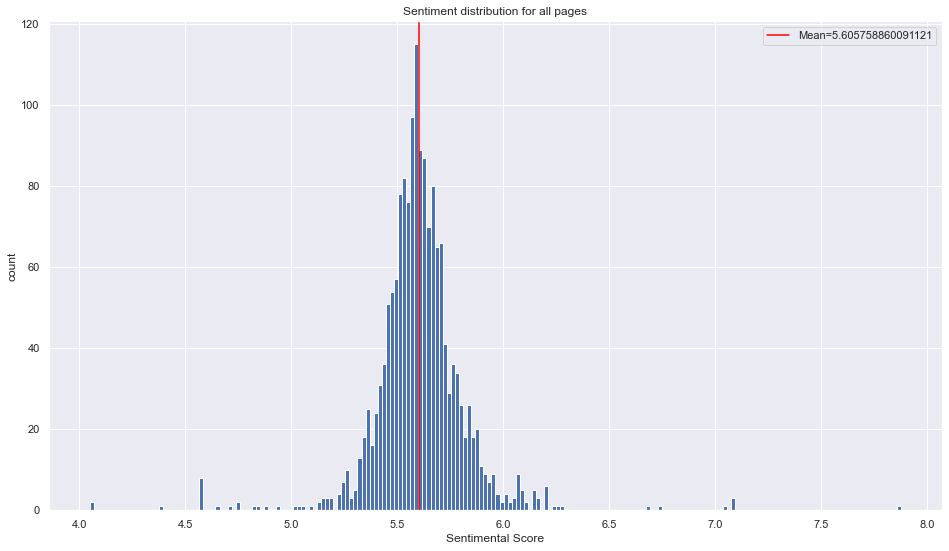

In [193]:
#Create a histogram of all character's associated page-sentiments.

plt.figure(figsize=(16,9))
plt.hist(pages_sentiment.values(),bins=200)
sent_mean = mean(list(pages_sentiment.values()))
plt.axvline(x=sent_mean, label=f'Mean={sent_mean}', c='red')
plt.legend()
plt.title('Sentiment distribution for all pages')
plt.ylabel('count')
plt.xlabel('Sentimental Score')

plt.show()

<font color='blue'>It can be seen clearly on the graph where the average sentiment is pretty neutral, or right above 5, meaning a bit more happier sentiment than unhappy. But we see where the curve flattens out to more happier or sadder pages, that we will dive deeper into below.

* **What are the 10 characters with happiest and saddest pages?**

In [184]:
print("\nHappiest pages: ")
happiest_heroes = pd.DataFrame(sorted(pages_sentiment.items(), reverse=True, key=lambda x: x[1])[:10], columns=["Page", "Sentiment"], index = range(1,11))
display(happiest_heroes)

print("\nUnhappiest pages: ")
happiest_heroes = pd.DataFrame(sorted(pages_sentiment.items(), reverse=False, key=lambda x: x[1])[:10], columns=["Page", "Sentiment"], index = range(1,11))
display(happiest_heroes)


Happiest pages: 


Page  Sentiment
1          Tower   7.880000
2           Post   7.080000
3         Hammer   7.080000
4            Zom   7.080000
5          Epoch   7.052000
6        Galacta   6.740000
7           Zero   6.680000
8    Free Spirit   6.285333
9      Tangerine   6.270667
10  Golden Woman   6.250000


Unhappiest pages: 


Page  Sentiment
1    Death-Stalker      4.050
2      Stuntmaster      4.050
3   Styx and Stone      4.380
4           Candra      4.575
5       Spoilsport      4.575
6          Dirtnap      4.575
7             Tusk      4.575
8        Dragoness      4.575
9         Punchout      4.580
10         Wipeout      4.580

<font color='blue'>If we take a look at the happiest characters we notice that those pages are really small and include few tokens that have sentiment value that is positive. To fix this a limit of words that have sentimental value is set, this limit was put to 50 frequencies but can be altered at will, but this is thought of as a good cut off based on the average median sentimental count. Now after removing the pages with too few sentimental words we we plot and generate the list again.

In [185]:
pages_sentiment_50 = {}
node_sentiment_50 = {}
for node in marvel_pages:
    sentiment_for_page = sentiment(nltk.FreqDist(marvel_pages[node]),50)
    if sentiment_for_page:
        pages_sentiment_50[node] = sentiment_for_page
    if node in Marvel_G_gcc_und.nodes():
        node_sentiment_50[node] = sentiment_for_page

# add the sentiment as attribute to the nodes 
# nx.set_node_attributes(Marvel_G_gcc_und, node_sentiment, "sentiment")

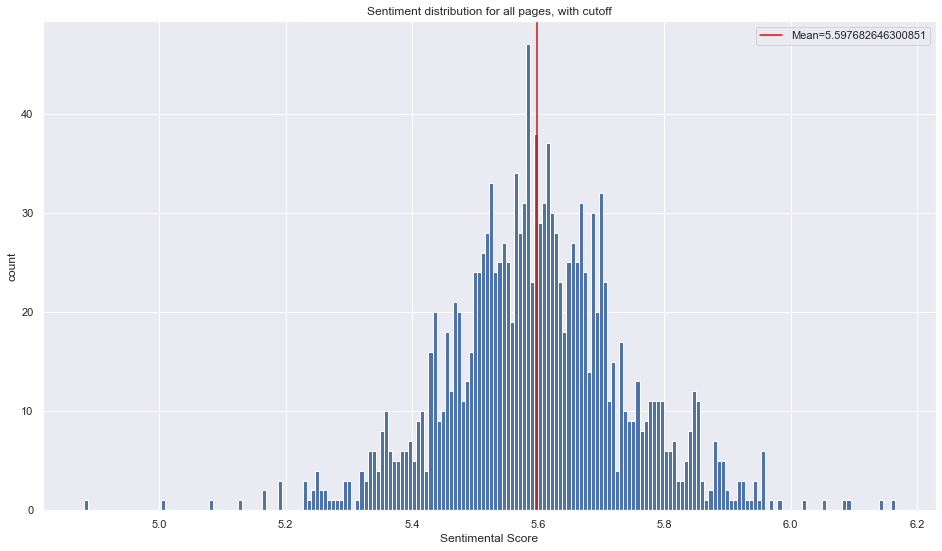

In [194]:
#Create a histogram of all character's associated page-sentiments.

plt.figure(figsize=(16,9))
plt.hist(pages_sentiment_50.values(),bins=200)
sent_mean_50 = mean(list(pages_sentiment_50.values()))
plt.axvline(x=sent_mean_50, label=f'Mean={sent_mean_50}', c='red')
plt.legend()
plt.title('Sentiment distribution for all pages, with cutoff')
plt.ylabel('count')
plt.xlabel('Sentimental Score')

plt.show()

<font color='blue'>Here we can clearly see the difference and the pages containing little text clearly represented nodes with more extreme happiness compared to others, since the range has gone down. The average sentiment is almost the same with less than 0.008 difference. Now lets check what our top pages are after the changes.

In [187]:
print("\nHappiest pages: ")
happiest_heroes = pd.DataFrame(sorted(pages_sentiment_50.items(), reverse=True, key=lambda x: x[1])[:10], columns=["Page", "Sentiment"], index = range(1,11))
display(happiest_heroes)

print("\nUnhappiest pages: ")
happiest_heroes = pd.DataFrame(sorted(pages_sentiment_50.items(), reverse=False, key=lambda x: x[1])[:10], columns=["Page", "Sentiment"], index = range(1,11))
display(happiest_heroes)


Happiest pages: 


Page  Sentiment
1             Dynamic Man   6.165437
2                Terminus   6.144407
3            Super Rabbit   6.092656
4               Hildegund   6.084286
5               Velocidad   6.056167
6             Honey Lemon   6.022260
7              Dreamqueen   5.982353
8   Lorna the Jungle Girl   5.968160
9      Dragon of the Moon   5.958472
10              Royal Roy   5.956974


Unhappiest pages: 


Page  Sentiment
1         Bullet   4.880057
2    Death Metal   5.008040
3   Savage Steel   5.084267
4          Trash   5.126067
5          Death   5.167951
6     Dark Beast   5.168268
7           Riot   5.188857
8       Redeemer   5.192344
9         Darter   5.192520
10     Holocaust   5.227829

<font color='blue'>If we take a look at the characters that are considered happiest and unhappiest, based on the sentiment score we can clearly see some pattern. If we look at the unhappiest the characters that first show up are criminals or characters that have done some evel, in the sense of killing kidnapping and other things. But when we look at the characters with happiest sentiment we are dealing with, protectors, service agents and generally good characters.

* If we look the happiest character Dynamic Man he would clearly be categorized as one of the good ones. Dynamic Man resolves to use his amazing powers for the betterment of humanity, which is pretty positive. But as we saw for the unhappier ones this doesn's always have to represent a good or bad character, for instance the 2nd happiest character is terminus which claimed the earth was his, which could be considered bad in some sense.
    
* For instance the unhappiest character is Bullet, who killed a man with acid and was a secret agent who allowed a terrorist attack on the the US Envorinmental organization, he is clearly considered a villain, which would be likely to be associated with more negative words. Similar things could be mentioned for Death Metal, which Bullet is associated with. But this doesn't always have to be accurate and for instance Savage Steel is the reference for a group or characters who used the Savage Steel armor to fight against criminals. This does therefore have many mentions of criminal,crime,kill that are all words with low score of sentiment.  
    
    
The takeway from looking at the top list is that in some cases the sentiment analysis can be useful but the context can also be lost and therefore bad words with good intentions been wrongfully taken.

* **Average the average sentiment of the nodes in each community to find a community level sentiment.**

<font color='blue'> Now we find the average sentiment for the communities and look for three happiest and saddest communities. Communities including only one character/node are skipped since they are only a "community" of one.

In [188]:
average_community_sent = {}
for com in list(community_included.keys()):
    total_sent = 0
    total_nodes = 0
    if len(community_included[com]) > 1: # remove communities that only have one node
        for node in community_included[com]:
            if pages_sentiment.get(node):
                total_nodes += 1
                total_sent += pages_sentiment[node]
        avg_cent = total_sent/total_nodes
        average_community_sent[com] = avg_cent

* **What are the three saddest communities?**
* **What are the three happiest communities?**

In [189]:
print("\nHappiest communities: ")
happiest_heroes = pd.DataFrame(sorted(average_community_sent.items(), reverse=True, key=lambda x: x[1])[:3], columns=["Community", "Sentiment"], index = range(1,4))
display(happiest_heroes)

print("\nUnhappiest communities: ")
happiest_heroes = pd.DataFrame(sorted(average_community_sent.items(), reverse=False, key=lambda x: x[1])[:3], columns=["Community", "Sentiment"], index = range(1,4))
display(happiest_heroes)


Happiest communities: 


Community  Sentiment
1  Jann of the Jungle|Lorna the Jungle Girl   5.961794
2         Super Rabbit|Ziggy Pig|Silly Seal   5.927062
3       Rockman|Phantom Reporter|Blue Blade   5.843035


Unhappiest communities: 


Community  Sentiment
1  Rebel Ralston|Junior Juniper|Pinky Pinkerton   5.379339
2                   Roughouse|Bloodscream|Geist   5.394340
3              Death's-Head|Woodgod|Death Metal   5.437732

* **Do these results confirm what you can learn about each community by skimming the wikipedia pages?**

<font color='blue'>Before diving into the characters in the community names lets plot the sentiments of the communities as we did for all the pages and see if the sentiment distribution has changed comapred to the individual pages.

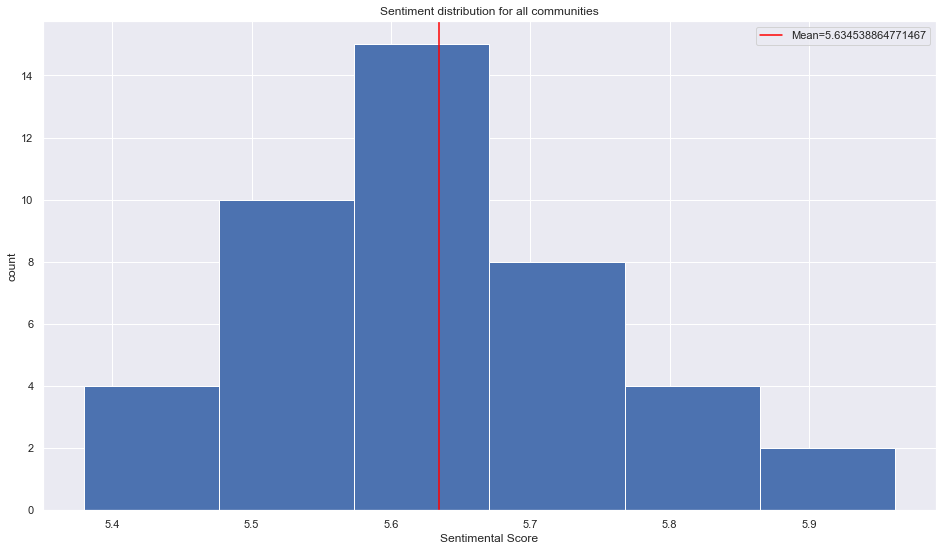

In [195]:
#Create a histogram of all character's associated community sentiments.

plt.figure(figsize=(16,9))
plt.hist(average_community_sent.values(),bins=6)
avg_mean = mean(list(average_community_sent.values()))
plt.axvline(x=avg_mean, label=f'Mean={avg_mean}', c='red')
plt.legend()
plt.title('Sentiment distribution for all communities')
plt.ylabel('count')
plt.xlabel('Sentimental Score')

plt.show()

<font color='blue'> By the histogram of communities sentiments we can see that the sentiment value has clearly gone closer to being more neutral, compared to the pages sentiment. The average sentimental score has gone down by 0.0287. This indicates that communities are more neutral then individual pages, this was kind of expected.


<font color='blue'> Let's analyze the happiest and saddest communities further. We'll start with the happiest 3:

1. ( Jann of the Jungle|Lorna the Jungle Girl ): This community consists of only two heroes (included in its title). *Jann of the Jungle´s* WikiPage redirects to *Jungle Tales*, a set of comic book stories set in the African jungle. The wiki includes a number of highly sentimental words, namely: 'Jungle' (5.69), 'Prince' (6.44), 'Nature', 7.24 and 'Star' (7.22). The second hero, Lorna the Jungle Girl is a protagonist in Marvel's *Lorna the Jungle Queen*. Lorna's WikiPage includes words such as 'Jungle' (5.69), 'Knight' (6.22), 'Adventure' (7.3), 'Friend' (7.66) and 'Father' (7.06). There's something very lively and uplifting about jungle-themed comics - and as such this result makes sense. 
    
2. ( Super Rabbit|Ziggy Pig|Silly Seal ): This community consists of 3 characters (included in the title). *Super Rabbit* is a funny, fictional parody of Super-Man. The character is quite lively, and their WikiPage includes words like 'Magic' (6.8), 'Strong' (7.06), 'Super' (7.68), 'Surprise' (7.42) and 'Funny' (a whopping 7.92). The other two characters, *Silly Seal*, and *Ziggy Pig* actually share the same WikiPage: *Ziggy Pig and Silly Seal*. These two are also quite funny animal characters, and as such include words such as 'Funny' (7.92), 'Humor' (7.72) and 'Children' (7.12). This community seems very uplifting and happy overall, and it should come as no surprise that it made its way on the toplist.

3. ( Rockman|Phantom Reporter|Blue Blade ): This community consists of 7 characters: *Phantom Reporter, Rockman, Fiery Mask, Captain Wonder, Blue Blade, Dynamic Man* and *Laughing Mask*. These characters were mostly part of *The Twelve*,  a collective of superheroes fighting the Nazis in the 1940s. In spite of being in comic-book form, the plot of this community is quite grown-up, revolving around plots of revenge, untimely deaths and even the infamous S.S. As such, this community being third in line is not necessarily expected. However, this could outline a limitation in sentiment analysis off of WikiPages, where the language is mostly kept neutral. In these pages, the words 'Super' (7.68), 'Strength' (7.4), 'Millionaire' (7.62), 'Golden' (7.3) and 'Wonder' (7.08) could be skewing the values abnormally for the pages in this community.
    
    
If we then look at the unhappiest communities: 
    
1. ( Rebel Ralston|Junior Juniper|Pinky Pinkerton ): The community consists of these three characters included in the title. The saddest page, Pinky Pinkerton, describes an English member of the *Howling Commandos*, fighting in World-War 2. Pinky replaced *Junior Juniper*, after Junior was killed in battle. Junior was the first major character to die in a Marvel comic. The WikiPages include many words that could be considered sad: 'Cancer' (1.54), 'Battle' (2.98), 'Died' (1.56) and 'Failed' (1.84). Rebel Ralston is part of the *Sgt. Fury and his Howling Commandos* WikiPage, which follows the same lines. Considering this, it's not surprising that this community is the saddest in the universe.
    
2. ( Roughouse|Bloodscream|Geist ): The community consists of these three characters included in the title. The saddest page, *Geist*, follows a DC character that becomes invisible. The page itself includes a lot of references to "Blood Pack". "Blood" (3.82) of course, is not a happy word. *Roughouse* is a supervillain, who finances themselves through illegal drug trade. *Bloodscream* is another villain, a "pseudo-vampire" that becomes increasingly cannibalistic in the Wolverine storyline. It is not surprising that this community does not get a particularly good sentimental score.
   
3. ( Death's-Head|Woodgod|Death Metal ): This community includes five heroes: *Tuck, Woodgod, Death Metal, Death's-Head* and *Death Wreck*. Off the bat, there is just a lot of 'Death' (1.54) in their names. *Death's Head* is a robotic bounty hunter, and *Death Wreck* and *Death Metal* were spin-off characters from the story arc. The stories do not seem to stand out in terms of brutality or something similar, but do include words such as 'Virus' (2.08), 'Shot' (2.5), 'Kill' (1.56) and 'Violent' (2.06). This, along with all the mention of 'Death' (1.54) could explain the sad rating the community gets.


In summary, the results are not all too surprising. Although some digging was necessary in some of the communities, there always seems to be at least some explanation for the average sentimental value of the community. This method is, however, not ideal for WikiPages. Wikipedia tries to stay neutral in narrative, and as such, the calculation can become very sensitive to a few words of negative sentiment. We tried to adjust for this effect here, but this fact of the data cannot be circumvented. This exercise did show, however, that some sentimental value can be extracted out of text fairly simply, particularly when the text is on either extreme of the sentimental spectrum.

**<font color='blue'>End of exercise 4</font>**